<a href="https://colab.research.google.com/github/UmaRamanathan-DA/HaggisHopper/blob/main/HaggisHopperTaxiDemand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
pip install tensorflow

In [3]:
# Keras is now part of TensorFlow, so you can install TensorFlow to use Keras.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# **Loading dataset**

In [4]:
url = "https://drive.google.com/uc?id=1svgeKk9f7gD4Y1indSgIIMbkzRwMsJTL"
geojson_url = "https://drive.google.com/uc?id=1Y1pfPt4TfVkWR_pmMPg7Dj4UCv8vT-Vj"
trip_data = pd.read_csv(url)

import folium
import geopandas as gpd
geo_data = gpd.read_file(geojson_url)

In [5]:
trip_data.head()

,Timestamp,Pickup Postcode,Dropoff Postcode,Distance (km),Duration (minutes),Fare Amount (£),Tip (%),Tip Amount (£),Total Amount (£),Payment Type,Passenger Count
0,2024-02-01 00:04:08,G227DU,G521NT,12.967,18.68,20.73,0.0%,0.0,20.73,Card,1
1,2024-02-01 00:04:41,G157XN,G158DL,1.219,2.93,6.35,0.0%,0.0,6.35,Card,2
2,2024-02-01 00:12:26,G312UG,G402LF,2.069,6.08,8.10,5.0%,0.4,8.50,Card,1
3,2024-02-01 00:21:45,G214LE,G226ER,3.179,6.20,8.97,0.0%,0.0,8.97,Card,1
4,2024-02-01 00:23:28,G226FB,G211XW,2.988,7.63,9.34,0.0%,0.0,9.34,Card,1


# **Basic Exploratory Data Analysis**

In [6]:
trip_data.shape

(3068, 11)

In [7]:
trip_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3068 entries, 0 to 3067
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Timestamp           3068 non-null   object 
 1   Pickup Postcode     3068 non-null   object 
 2   Dropoff Postcode    3068 non-null   object 
 3   Distance (km)       3068 non-null   float64
 4   Duration (minutes)  3068 non-null   float64
 5   Fare Amount (£)     3068 non-null   float64
 6   Tip (%)             3068 non-null   object 
 7   Tip Amount (£)      3068 non-null   float64
 8   Total Amount (£)    3068 non-null   float64
 9   Payment Type        3068 non-null   object 
 10  Passenger Count     3068 non-null   int64  
dtypes: float64(5), int64(1), object(5)
memory usage: 263.8+ KB


In [8]:
trip_data.describe()

,Distance (km),Duration (minutes),Fare Amount (£),Tip Amount (£),Total Amount (£),Passenger Count
count,3068.000000,3068.000000,3068.000000,3068.000000,3068.000000,3068.000000
mean,7.385387,18.080026,15.484824,0.344436,15.961336,1.390482
std,8.061225,10.100233,9.167108,0.646640,9.273909,0.539355
min,0.006000,0.020000,3.310000,0.000000,3.310000,1.000000
25%,4.463500,12.700000,11.850000,0.000000,12.180000,1.000000
50%,6.755500,17.140000,15.080000,0.000000,15.520000,1.000000
75%,9.609500,23.085000,18.672500,0.592500,19.242500,2.000000
max,402.510000,388.880000,442.590000,4.150000,442.590000,3.000000


In [9]:
trip_data.isnull().sum().sum()

0

In [10]:
trip_data.columns

Index(['Timestamp', 'Pickup Postcode', 'Dropoff Postcode', 'Distance (km)',
       'Duration (minutes)', 'Fare Amount (£)', 'Tip (%)', 'Tip Amount (£)',
       'Total Amount (£)', 'Payment Type', 'Passenger Count'],
      dtype='object')

# **Basic Data Cleaning**

## Removing trips of 'Duration (minutes)' less than 1 minute

In [11]:
# Step 1: Filter out rows where 'Duration (minutes)' is less than 1
trip_data = trip_data[trip_data['Duration (minutes)'] >= 1]

# Step 2: Verify the updated dataset
print(f"Rows remaining after removing trips with duration < 1 minute: {trip_data.shape[0]}")
print(trip_data.head())

Rows remaining after removing trips with duration < 1 minute: 3061
             Timestamp Pickup Postcode Dropoff Postcode  Distance (km)  \
0  2024-02-01 00:04:08          G227DU           G521NT         12.967   
1  2024-02-01 00:04:41          G157XN           G158DL          1.219   
2  2024-02-01 00:12:26          G312UG           G402LF          2.069   
3  2024-02-01 00:21:45          G214LE           G226ER          3.179   
4  2024-02-01 00:23:28          G226FB           G211XW          2.988   

   Duration (minutes)  Fare Amount (£) Tip (%)  Tip Amount (£)  \
0               18.68            20.73    0.0%             0.0   
1                2.93             6.35    0.0%             0.0   
2                6.08             8.10    5.0%             0.4   
3                6.20             8.97    0.0%             0.0   
4                7.63             9.34    0.0%             0.0   

   Total Amount (£) Payment Type  Passenger Count  
0             20.73         Card       

# **Feature Engineering**

In [12]:
df_cleansed = trip_data

## Adding new Country column

In [13]:
# Add a new column "Country" with value "United Kingdom"
df_cleansed['Country'] = 'United Kingdom'

## Adding new Columns "PostCodeArea_PickUp" and "PostCodeArea_Dropoff"

In [14]:
# Function to extract postcode area
def extract_postcode_area(postcode):
    if len(postcode) == 6:
        return postcode[:3]
    elif len(postcode) == 5:
        return postcode[:2]
    else:
        return None

# Apply function to create postcode area column
df_cleansed['PostCodeArea_PickUp'] = df_cleansed['Pickup Postcode'].apply(extract_postcode_area)
df_cleansed['PostCodeArea_Dropoff'] = df_cleansed['Dropoff Postcode'].apply(extract_postcode_area)
df_cleansed[['Pickup Postcode', 'PostCodeArea_PickUp', 'Dropoff Postcode', 'PostCodeArea_Dropoff' ]]

,Pickup Postcode,PostCodeArea_PickUp,Dropoff Postcode,PostCodeArea_Dropoff
0,G227DU,G22,G521NT,G52
1,G157XN,G15,G158DL,G15
2,G312UG,G31,G402LF,G40
3,G214LE,G21,G226ER,G22
4,G226FB,G22,G211XW,G21
...,...,...,...,...
3063,G132HU,G13,G235BP,G23
3064,G36ND,G3,G158DZ,G15
3065,G29TX,G2,G521SW,G52
3066,G132RJ,G13,G427NF,G42


## Correcting Postcode

In [15]:
# Regular expression pattern for UK postcode
postcode_pattern = re.compile(r'^[A-Z]{1,2}\d[A-Z\d]? \d[A-Z]{2}$')

# Function to validate and correct postcodes
def validate_and_correct_postcode(postcode):
    # Check if the postcode matches the pattern
    if re.match(postcode_pattern, postcode):
        return postcode  # Return the postcode if it's valid
    else:
        # Try to correct the postcode
        if len(postcode) == 6:
            corrected_postcode = postcode[:3] + ' ' + postcode[3:]
        elif len(postcode) == 5:
            corrected_postcode = postcode[:2] + ' ' + postcode[2:]
        else:
            return None  # Return None if the length of the postcode is not valid

        if re.match(postcode_pattern, corrected_postcode):
            return corrected_postcode  # Return the corrected postcode if it matches the pattern
        else:
            return None  # Return None if the postcode cannot be corrected

# Apply the function to the 'Postcode' column
df_cleansed['Corrected Pickup Postcode'] = df_cleansed['Pickup Postcode'].apply(validate_and_correct_postcode)

df_cleansed[['Pickup Postcode','Corrected Pickup Postcode', 'PostCodeArea_PickUp']].head()


,Pickup Postcode,Corrected Pickup Postcode,PostCodeArea_PickUp
0,G227DU,G22 7DU,G22
1,G157XN,G15 7XN,G15
2,G312UG,G31 2UG,G31
3,G214LE,G21 4LE,G21
4,G226FB,G22 6FB,G22


## Correcting Drop Off Postcode

In [16]:
# Regular expression pattern for UK postcode
postcode_pattern = re.compile(r'^[A-Z]{1,2}\d[A-Z\d]? \d[A-Z]{2}$')

# Function to validate and correct postcodes
def validate_and_correct_postcode(postcode):
    # Check if the postcode matches the pattern
    if re.match(postcode_pattern, postcode):
        return postcode  # Return the postcode if it's valid
    else:
        # Try to correct the postcode
        if len(postcode) == 6:
            corrected_postcode = postcode[:3] + ' ' + postcode[3:]
        elif len(postcode) == 5:
            corrected_postcode = postcode[:2] + ' ' + postcode[2:]
        else:
            return None  # Return None if the length of the postcode is not valid

        if re.match(postcode_pattern, corrected_postcode):
            return corrected_postcode  # Return the corrected postcode if it matches the pattern
        else:
            return None  # Return None if the postcode cannot be corrected

# Apply the function to the 'Postcode' column
df_cleansed['Corrected Dropoff Postcode'] = df_cleansed['Dropoff Postcode'].apply(validate_and_correct_postcode)

df_cleansed[['Pickup Postcode', 'Corrected Pickup Postcode','PostCodeArea_PickUp', 'Dropoff Postcode', 'Corrected Dropoff Postcode']].head()

,Pickup Postcode,Corrected Pickup Postcode,PostCodeArea_PickUp,Dropoff Postcode,Corrected Dropoff Postcode
0,G227DU,G22 7DU,G22,G521NT,G52 1NT
1,G157XN,G15 7XN,G15,G158DL,G15 8DL
2,G312UG,G31 2UG,G31,G402LF,G40 2LF
3,G214LE,G21 4LE,G21,G226ER,G22 6ER
4,G226FB,G22 6FB,G22,G211XW,G21 1XW


## Adding columns for Latitudes and Longitudes for Corrected Pick Up Postcodes and Corrected Drop Off Postcodes

In [17]:
pip install pgeocode

In [18]:
import pgeocode
nomi = pgeocode.Nominatim('GB')

# Function to query postcode info
def get_postcode_info(postcode):
    result = nomi.query_postal_code(postcode)
    if pd.isna(result.latitude):
        return pd.Series({'latitude': None, 'longitude': None, 'place_name': None, 'county_name': None})
    return pd.Series({
        'latitude': result.latitude,
        'longitude': result.longitude,
        'place_name': result.place_name,
        'county_name': result.county_name
    })

# Apply the function to populate the columns
postcode_info = df_cleansed['Corrected Pickup Postcode'].apply(get_postcode_info)
df_cleansed[['latitude_p', 'longitude_p', 'place_name_p', 'county_name_p']] = postcode_info

postcode_info = df_cleansed['Corrected Dropoff Postcode'].apply(get_postcode_info)
df_cleansed[['latitude_d', 'longitude_d', 'place_name_d', 'county_name_d']] = postcode_info

df_cleansed.head(2)

,Timestamp,Pickup Postcode,Dropoff Postcode,Distance (km),Duration (minutes),Fare Amount (£),Tip (%),Tip Amount (£),Total Amount (£),Payment Type,...,Corrected Pickup Postcode,Corrected Dropoff Postcode,latitude_p,longitude_p,place_name_p,county_name_p,latitude_d,longitude_d,place_name_d,county_name_d
0,2024-02-01 00:04:08,G227DU,G521NT,12.967,18.68,20.73,0.0%,0.0,20.73,Card,...,G22 7DU,G52 1NT,55.8651,-4.2576,Glasgow,Dunbartonshire,55.8479,-4.3503,Glasgow,Dunbartonshire
1,2024-02-01 00:04:41,G157XN,G158DL,1.219,2.93,6.35,0.0%,0.0,6.35,Card,...,G15 7XN,G15 8DL,55.9102,-4.3733,Drumchapel,Glasgow City,55.9102,-4.3733,Drumchapel,Glasgow City


In [19]:
df_cleansed.isnull().sum().sum()

0

## Adding Temporal Columns

In [20]:
df_cleansed['Timestamp'] = pd.to_datetime(df_cleansed['Timestamp'])

df_cleansed['Hour of the day'] = df_cleansed['Timestamp'].dt.hour
df_cleansed['Day of the month'] = df_cleansed['Timestamp'].dt.day
df_cleansed['Day_of_Week_num'] = df_cleansed['Timestamp'].dt.dayofweek  # 0 = Monday, 6 = Sunday
df_cleansed['Day of the week'] = df_cleansed['Timestamp'].dt.day_name()

## Adding new columns to flag holidays and holiday types

In [21]:
# Convert 'Timestamp' column to datetime format
df_cleansed['IsHoliday'] = 'No'
df_cleansed['HolidayType'] = ''

## Adding Approximate Revenue per km column

In [22]:
# Step 1: Calculate revenue per km
df_cleansed['Revenue_per_km'] = df_cleansed['Fare Amount (£)'] / df_cleansed['Distance (km)']

# Step 2: Handle potential division by zero
df_cleansed['Revenue_per_km'] = df_cleansed['Revenue_per_km'].replace([float('inf'), -float('inf')], None)

## Adding Demand Column: Preprocessing data for forecasting models
Aggregating hourly demand and updating the column in the main dataset

In [23]:
df_cleansed['Timestamp_Hourly'] = df_cleansed['Timestamp'].dt.floor('H')
data = df_cleansed.copy()
data.reset_index(inplace=True)
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data.set_index('Timestamp', inplace=True)

# Step 2: Aggregate data to hourly demand/frequency (dependant variable for forecasting model)
# hourly_demand = data.resample('h').size()  # Resample data to hourly frequency
hourly_demand = data.resample('h').size().reset_index(name='Demand')
hourly_demand = hourly_demand.set_index('Timestamp')

# Extract the numeric series for decomposition
demand_series = hourly_demand['Demand']

In [24]:
# Merge datasets
data_processed = pd.merge(data, hourly_demand, left_on='Timestamp_Hourly', right_on='Timestamp', how='left')

## Integrating Weather Data

## Integrating Holidays/Events

In [25]:
# Marking weekends - Sat and Sun
df_cleansed['Day of the week'].value_counts()

,count
Day of the week,
Thursday,566
Wednesday,499
Monday,425
Tuesday,423
Friday,417
Saturday,413
Sunday,318


In [26]:
df_cleansed['IsHoliday'] = df_cleansed['Day of the week'].apply(
    lambda x: 'Yes' if x in ['Saturday', 'Sunday'] else 'No'
)

df_cleansed['HolidayType'] =  df_cleansed['Day of the week'].apply(
    lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else None
)

In [27]:
df_cleansed['IsHoliday'].value_counts()

,count
IsHoliday,
No,2330
Yes,731


In [28]:
df_cleansed['HolidayType'].value_counts()

,count
HolidayType,
Weekend,731


In [29]:
import requests

# Fetch bank holidays for Scotland
url = "https://www.gov.uk/bank-holidays.json"
response = requests.get(url)
data = response.json()

# Extract 2024 holidays for Scotland
scotland_holidays = data['scotland']['events']
holidays_2024 = [event['date'] for event in scotland_holidays if event['date'].startswith('2024')]
holidays_2024


['2024-01-01',
 '2024-01-02',
 '2024-03-29',
 '2024-05-06',
 '2024-05-27',
 '2024-08-05',
 '2024-12-02',
 '2024-12-25',
 '2024-12-26']

In [30]:
# Mark bank holidays as holidays
df_cleansed['IsHoliday'] = df_cleansed.apply(
    lambda row: 'Yes' if row['Timestamp'].date().strftime('%Y-%m-%d') in holidays_2024 else row['IsHoliday'],
    axis=1
)

df_cleansed['HolidayType'] = df_cleansed.apply(
    lambda row: 'bank-holiday' if row['Timestamp'].date().strftime('%Y-%m-%d') in holidays_2024 else row['HolidayType'],
    axis=1
)

In [31]:
df_cleansed['HolidayType'].value_counts()

,count
HolidayType,
Weekend,731


## Integrating Traffic Data

# **Missing Values**

In [32]:
data_processed.isnull().sum()

,0
index,0
Pickup Postcode,0
Dropoff Postcode,0
Distance (km),0
Duration (minutes),0
Fare Amount (£),0
Tip (%),0
Tip Amount (£),0
Total Amount (£),0
Payment Type,0


# **Outliers**

Columns with extreme outliers: ['Distance (km)', 'Duration (minutes)', 'Fare Amount (£)', 'Tip Amount (£)', 'Total Amount (£)', 'Revenue_per_km']


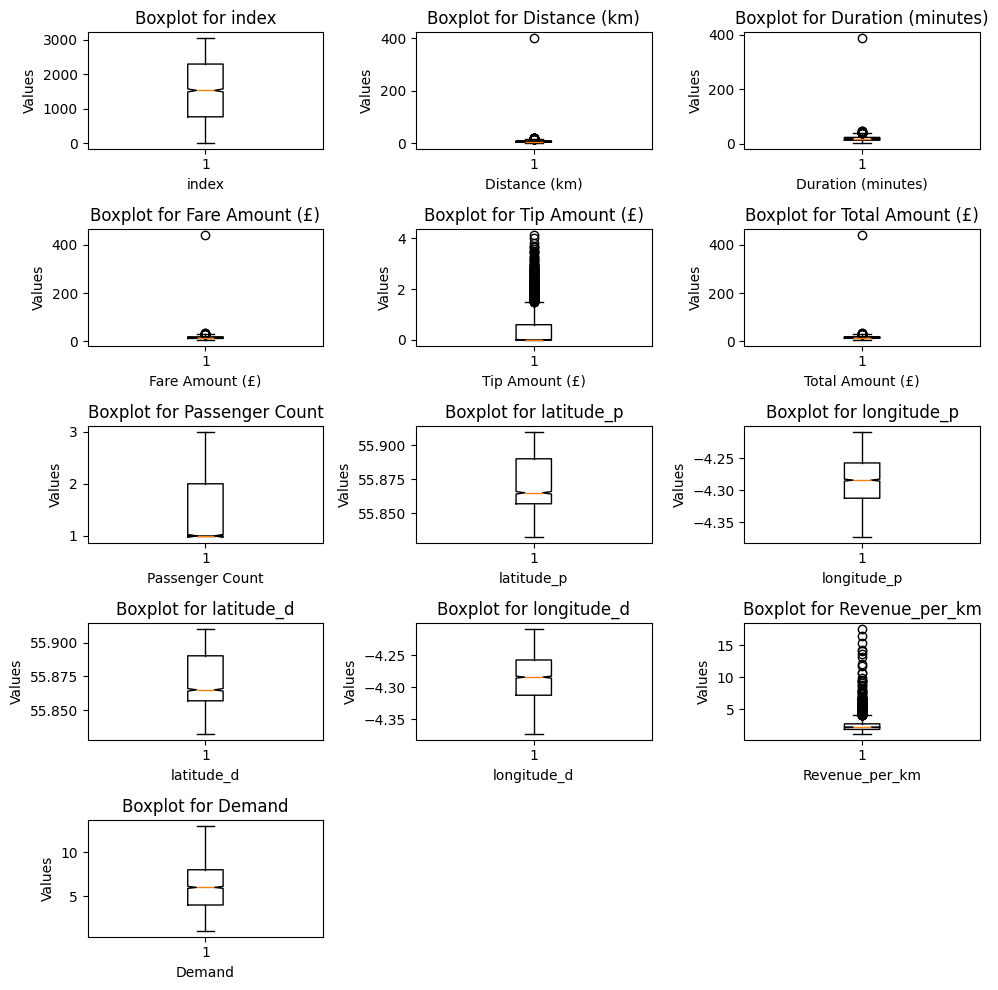

In [33]:
# Identify numeric columns
numeric_columns = [col for col in data_processed.columns if data_processed[col].dtypes in ["int64", "float64"]]

# Initialize a list to store columns with extreme outliers
columns_with_outliers = []

# Set thresholds for extreme outliers using IQR
for col_name in numeric_columns:
    # Calculate Q1, Q3, and IQR
    Q1 = data_processed[col_name].quantile(0.25)
    Q3 = data_processed[col_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Check if the column has outliers
    if ((data_processed[col_name] < lower_bound).any() or (data_processed[col_name] > upper_bound).any()):
        columns_with_outliers.append(col_name)

# Print the list of columns with extreme outliers
print("Columns with extreme outliers:", columns_with_outliers)

# Plot boxplots for each numeric column
n_cols = 3
n_rows = int(np.ceil(len(numeric_columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 2 * n_rows))
axes = axes.flatten()  # Flatten the array of axes for easy indexing

# Plot boxplots for each numeric column
for i, col_name in enumerate(numeric_columns):
    axes[i].boxplot(data_processed[col_name], notch=True)
    axes[i].set_title(f"Boxplot for {col_name}")
    axes[i].set_xlabel(col_name)
    axes[i].set_ylabel("Values")

# Hide any unused subplots
for j in range(len(numeric_columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

## Analysing Skewness for columns with outliers

In [34]:
# Calculate skewness for all columns in the list of columns with extreme outliers
skewness_results = {col: data_processed[col].skew() for col in columns_with_outliers}

# Print skewness results with interpretation
print("Skewness for columns with extreme outliers and interpretation:")
for col, skewness in skewness_results.items():
    # Determine interpretation based on skewness value
    interpretation = (
        "Symmetric" if abs(skewness) < 0.5 else
        "Moderately Skewed" if 0.5 <= abs(skewness) < 1 else
        "Highly Skewed"
    )
    # Determine the skew direction
    skew_direction = "Positive Skew (Right Tail)" if skewness > 0 else "Negative Skew (Left Tail)"
    # Print results
    print(f"{col}: Skewness = {skewness:.2f} | {interpretation} | {skew_direction}")

Skewness for columns with extreme outliers and interpretation:
Distance (km): Skewness = 38.53 | Highly Skewed | Positive Skew (Right Tail)
Duration (minutes): Skewness = 16.44 | Highly Skewed | Positive Skew (Right Tail)
Fare Amount (£): Skewness = 33.17 | Highly Skewed | Positive Skew (Right Tail)
Tip Amount (£): Skewness = 2.21 | Highly Skewed | Positive Skew (Right Tail)
Total Amount (£): Skewness = 31.94 | Highly Skewed | Positive Skew (Right Tail)
Revenue_per_km: Skewness = 4.82 | Highly Skewed | Positive Skew (Right Tail)


## Analysing histograms for all numerical columns

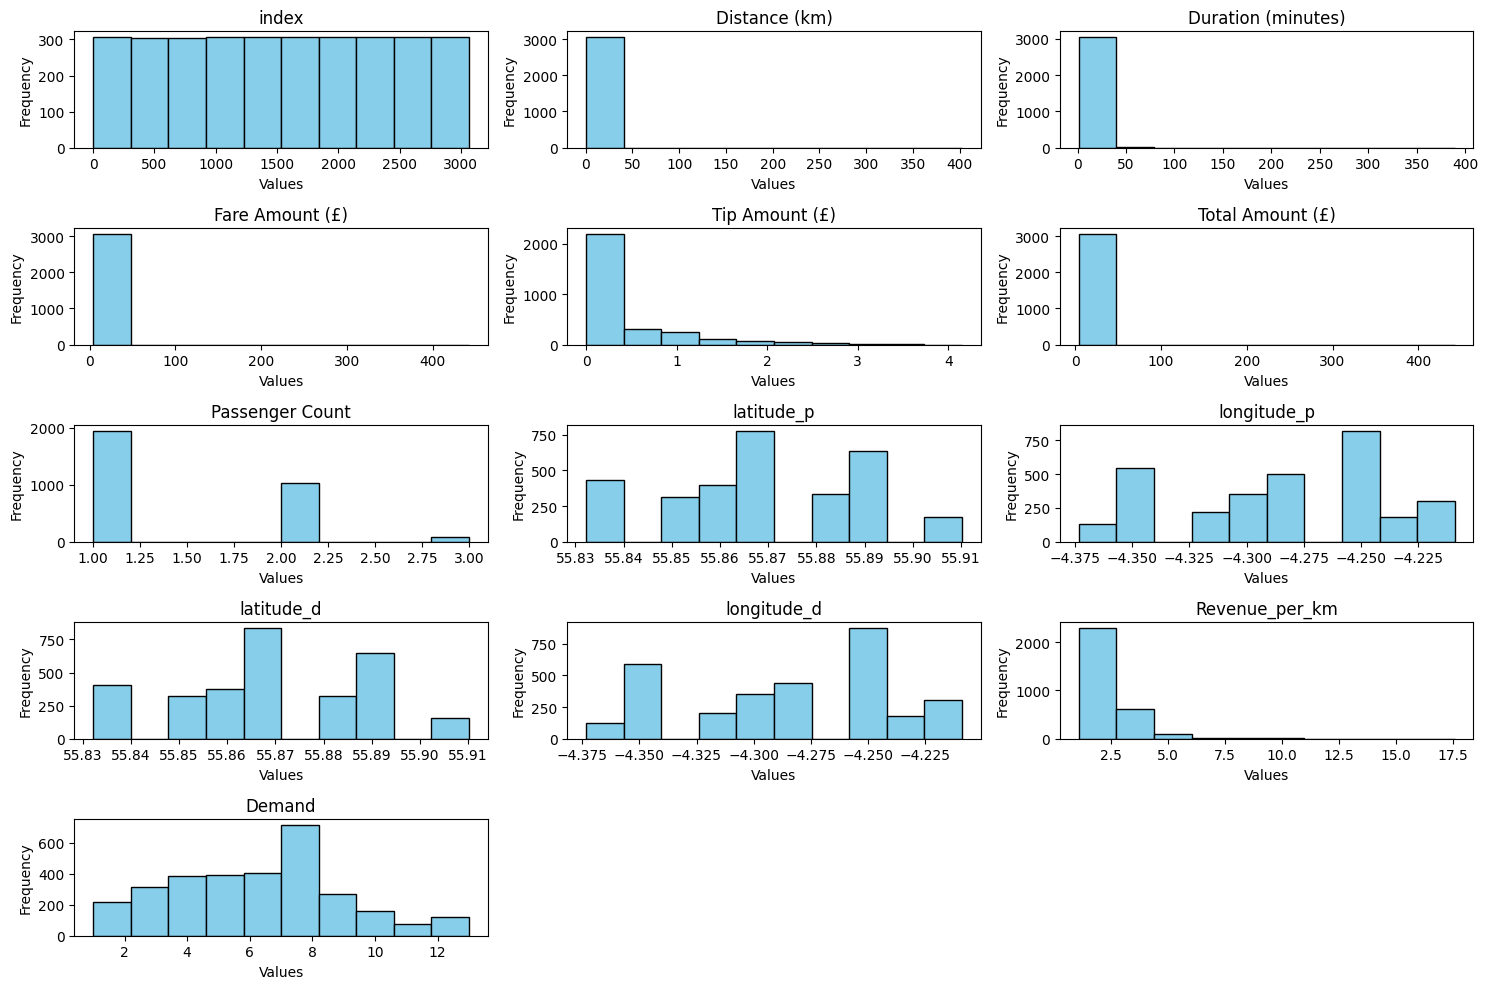

In [35]:
numeric_columns = data_processed.select_dtypes(include=["int64", "float64"]).columns
fig, axes = plt.subplots(len(numeric_columns) // 3 + 1, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col_name in enumerate(numeric_columns):
    axes[i].hist(data_processed[col_name], bins=10, color='skyblue', edgecolor='black')
    axes[i].set_title(col_name)
    axes[i].set_xlabel("Values")
    axes[i].set_ylabel("Frequency")

# Hide unused subplots
for ax in axes[len(numeric_columns):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

## Removing Outliers

In [36]:
columns_with_outliers

['Distance (km)',
 'Duration (minutes)',
 'Fare Amount (£)',
 'Tip Amount (£)',
 'Total Amount (£)',
 'Revenue_per_km']

In [37]:
data_processed_o = data_processed.copy()

In [38]:
# Removing all outliers for these columns in columns_with_outliers

# Standard IQR multiplier
iqr_multiplier = 1.5  # Adjust as needed (1.5 is standard for IQR)

# Loop through each column and remove outliers
for col in columns_with_outliers:
    # Calculate Q1, Q3, and IQR
    Q1 = data_processed_o[col].quantile(0.25)
    Q3 = data_processed_o[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define the outlier thresholds
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR

    # Filter the DataFrame to exclude outliers
    data_processed_o = data_processed_o[(data_processed_o[col] >= lower_bound) & (data_processed_o[col] <= upper_bound)]

# Display the cleaned DataFrame and its size
print(f"Dataset before outliers removed: {data_processed.shape[0]} rows")
print(f"Dataset after outliers removed: {data_processed_o.shape[0]} rows")

Dataset before outliers removed: 3061 rows
Dataset after outliers removed: 2604 rows


## Validating data after removing outliers

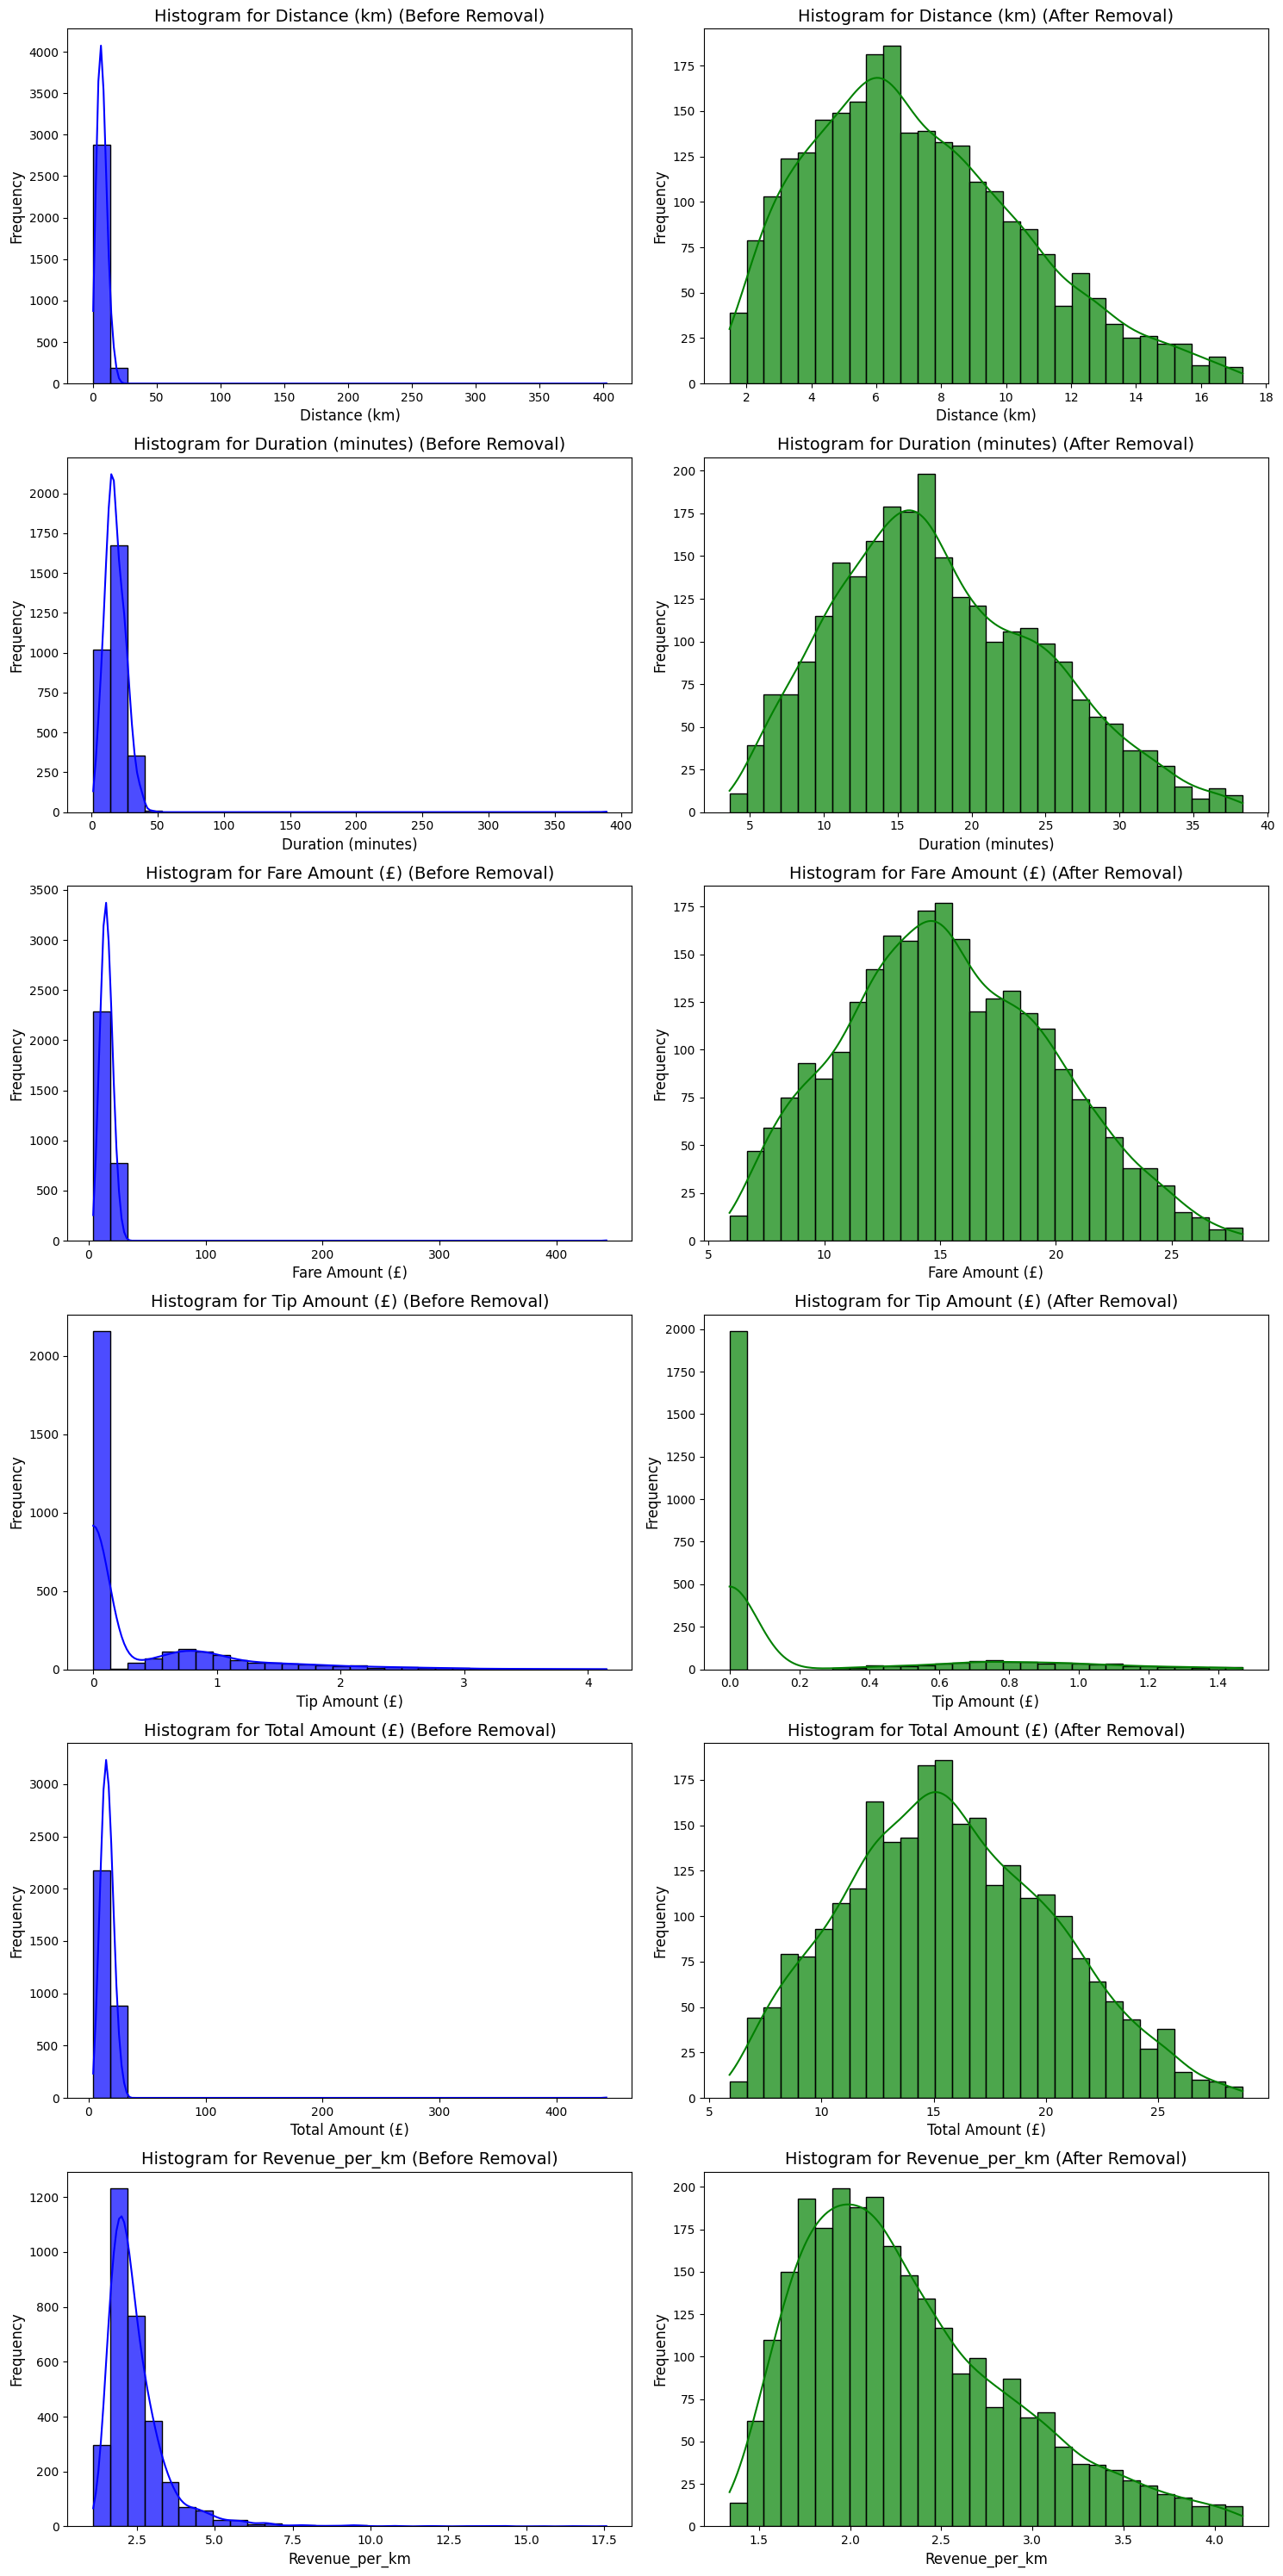

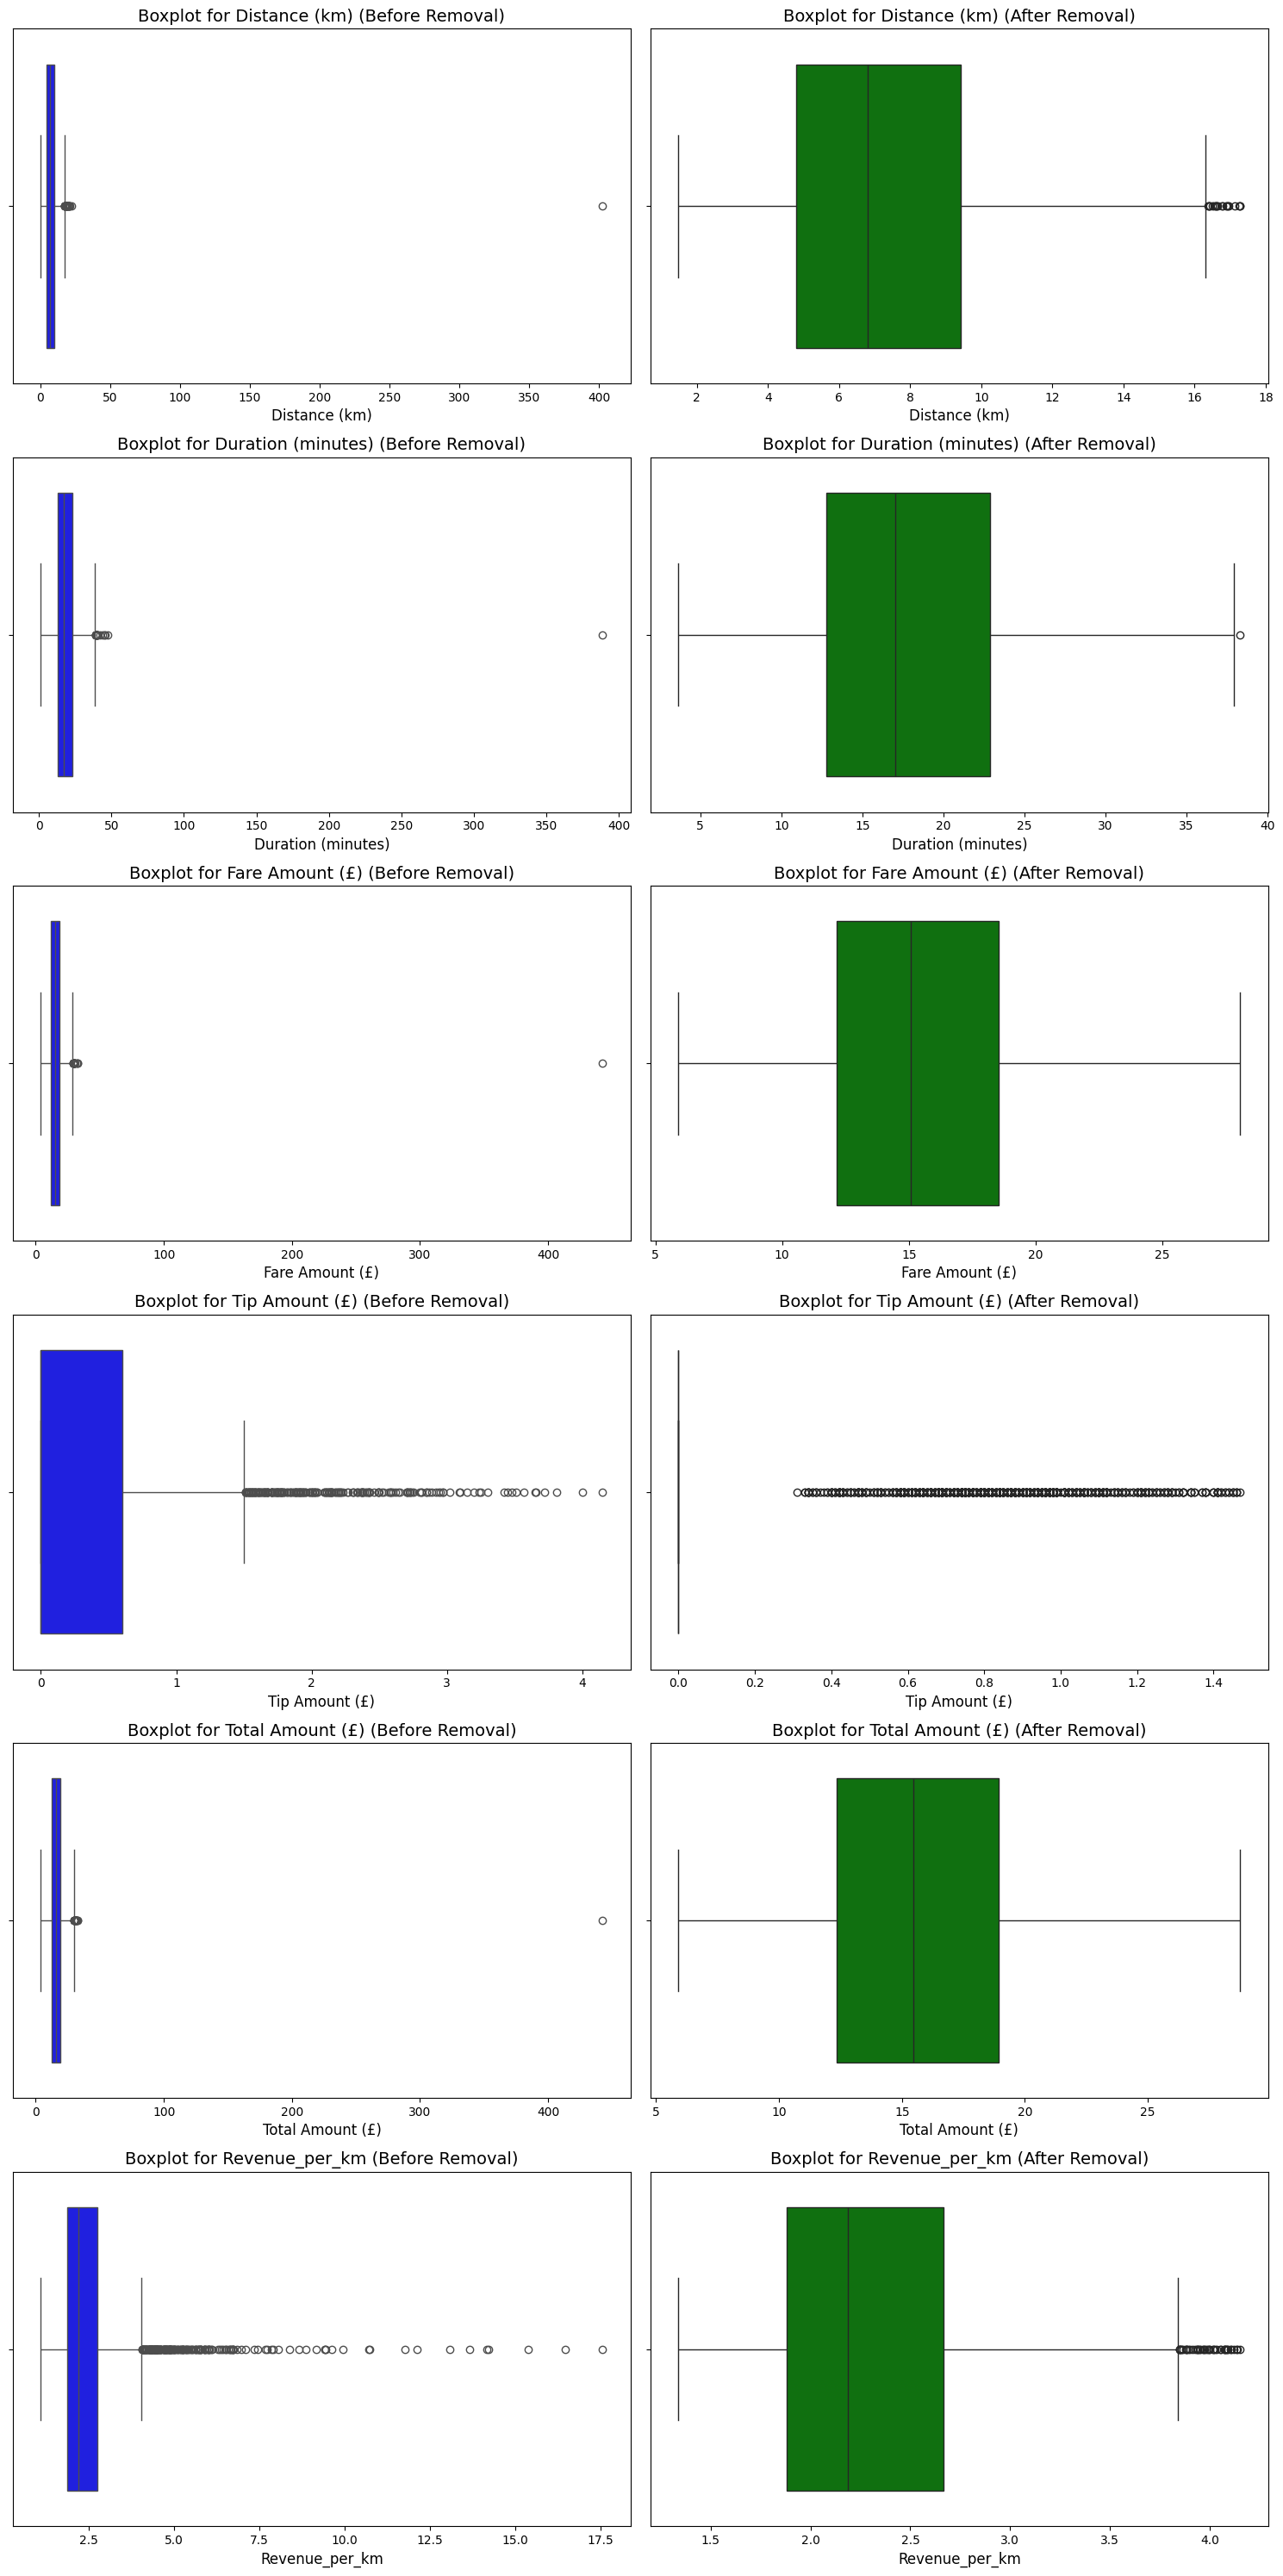

In [39]:
# Create subplots for comparison of histograms
n_cols = 2  # Side-by-side comparison: Before and After
n_rows = len(columns_with_outliers)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Loop through each column and plot histograms before and after outlier removal
for i, col in enumerate(columns_with_outliers):
    # Histogram: Before outlier removal
    sns.histplot(data_processed[col], kde=True, bins=30, ax=axes[i, 0], color='blue', alpha=0.7)
    axes[i, 0].set_title(f"Histogram for {col} (Before Removal)", fontsize=14)
    axes[i, 0].set_xlabel(col, fontsize=12)
    axes[i, 0].set_ylabel("Frequency", fontsize=12)

    # Histogram: After outlier removal
    sns.histplot(data_processed_o[col], kde=True, bins=30, ax=axes[i, 1], color='green', alpha=0.7)
    axes[i, 1].set_title(f"Histogram for {col} (After Removal)", fontsize=14)
    axes[i, 1].set_xlabel(col, fontsize=12)
    axes[i, 1].set_ylabel("Frequency", fontsize=12)

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

# Create subplots for comparison of boxplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

# Loop through each column and plot boxplots before and after outlier removal
for i, col in enumerate(columns_with_outliers):
    # Boxplot: Before outlier removal
    sns.boxplot(x=data_processed[col], ax=axes[i, 0], color='blue')
    axes[i, 0].set_title(f"Boxplot for {col} (Before Removal)", fontsize=14)
    axes[i, 0].set_xlabel(col, fontsize=12)

    # Boxplot: After outlier removal
    sns.boxplot(x=data_processed_o[col], ax=axes[i, 1], color='green')
    axes[i, 1].set_title(f"Boxplot for {col} (After Removal)", fontsize=14)
    axes[i, 1].set_xlabel(col, fontsize=12)

# Adjust layout for better visibility
plt.tight_layout()
plt.show()


In [40]:
# Calculate skewness for all columns in the list of columns with extreme outliers
skewness_results = {col: data_processed_o[col].skew() for col in columns_with_outliers}

# Print skewness results with interpretation
print("Skewness for columns with extreme outliers and interpretation:")
for col, skewness in skewness_results.items():
    # Determine interpretation based on skewness value
    interpretation = (
        "Symmetric" if abs(skewness) < 0.5 else
        "Moderately Skewed" if 0.5 <= abs(skewness) < 1 else
        "Highly Skewed"
    )
    # Determine the skew direction
    skew_direction = "Positive Skew (Right Tail)" if skewness > 0 else "Negative Skew (Left Tail)"
    # Print results
    print(f"{col}: Skewness = {skewness:.2f} | {interpretation} | {skew_direction}")

Skewness for columns with extreme outliers and interpretation:
Distance (km): Skewness = 0.58 | Moderately Skewed | Positive Skew (Right Tail)
Duration (minutes): Skewness = 0.42 | Symmetric | Positive Skew (Right Tail)
Fare Amount (£): Skewness = 0.22 | Symmetric | Positive Skew (Right Tail)
Tip Amount (£): Skewness = 1.63 | Highly Skewed | Positive Skew (Right Tail)
Total Amount (£): Skewness = 0.23 | Symmetric | Positive Skew (Right Tail)
Revenue_per_km: Skewness = 0.84 | Moderately Skewed | Positive Skew (Right Tail)


# **Encoding categorical variables**

In [41]:
# Example: Ensure 'HolidayType' is categorical
if data_processed_o['HolidayType'].dtype == 'object':
    # Convert 'HolidayType' to numerical form using label encoding
    data_processed_o['HolidayType_Encoded'] = data_processed_o['HolidayType'].astype('category').cat.codes

data_processed_o['HolidayType_Encoded'].value_counts()

,count
HolidayType_Encoded,
0,2604


In [42]:
data_processed_o['Payment Type'].value_counts()

,count
Payment Type,
Card,1821
Cash,418
Unknown,365


In [43]:
# Encode 'payment_type' column into numerical values
if data_processed_o['Payment Type'].dtype == 'object':
    data_processed_o['payment_type_Encoded'] = data_processed_o['Payment Type'].astype('category').cat.codes

# Display the first few rows to verify encoding
print(data_processed_o[['Payment Type', 'payment_type_Encoded']].head())

  Payment Type  payment_type_Encoded
0         Card                     0
2         Card                     0
3         Card                     0
4         Card                     0
5         Card                     0




---



# **Data Visualisations**

## **Demand Density by location**


In [44]:
# Aggregate demand by latitude and longitude
location_demand = data_processed_o.groupby(['latitude_p', 'longitude_p'])['Demand'].sum().reset_index()
location_demand.columns = ['Latitude', 'Longitude', 'Total Demand']

In [45]:
import folium
from folium.plugins import HeatMap

# Create a base map
m = folium.Map(location=[location_demand['Latitude'].mean(), location_demand['Longitude'].mean()], zoom_start=12)

# Add a heatmap layer
heat_data = location_demand[['Latitude', 'Longitude', 'Total Demand']].values.tolist()
HeatMap(heat_data).add_to(m)

# Display the map
m.save("Demand_Heatmap.html")  # Save the map as an HTML file
m  # Display the map (works in Jupyter or Colab)

### Geographic hotspots of demand - Demand Density by post code areas

Define geographic areas: Determine the granularity at which you want to analyze demand density. This could be at the level of postal code areas, administrative regions, or custom-defined regions.

Aggregate demand: Count the number of taxi pickups or requests within each geographic area. You can group the data by the chosen geographic area and count the number of records (rows) within each group.

Normalize demand: To account for variations in the size of geographic areas, you may want to normalize the demand density. This could involve dividing the count of taxi pickups by the area's size or population.

## **Identifying high demand post code areas, contributing to 80% of the demand**

In [46]:
# Aggregate trip counts (demand) by postcode area
postcode_demand = data_processed_o.groupby('PostCodeArea_PickUp').size().reset_index(name='Demand')

# Define a threshold for high demand areas (e.g., 80th percentile of demand)
high_demand_threshold = postcode_demand['Demand'].quantile(0.80)

# Filter high demand areas
high_demand_areas = postcode_demand[postcode_demand['Demand'] >= high_demand_threshold]

# Display high demand areas
print("High Demand Postcode Areas:")
print(high_demand_areas)

# Number of high demand areas
print(f"\nNumber of High Demand Areas: {high_demand_areas.shape[0]}")


High Demand Postcode Areas:
   PostCodeArea_PickUp  Demand
2                  G12     195
3                  G13     213
15                 G41     225
18                 G51     196

Number of High Demand Areas: 4


In [47]:
# Aggregate trip counts (demand) by postcode area and include place names
postcode_demand_with_place = data_processed_o.groupby(['PostCodeArea_PickUp', 'place_name_p']).size().reset_index(name='Demand')

# Define a threshold for high demand areas (e.g., 90th percentile of demand)
high_demand_threshold = postcode_demand_with_place['Demand'].quantile(0.90)

# Filter high demand areas
high_demand_areas_with_place = postcode_demand_with_place[postcode_demand_with_place['Demand'] >= high_demand_threshold]

# Display high demand areas with place names
print("High Demand Postcode Areas with Place Names:")
print(high_demand_areas_with_place)

# Number of high demand areas
print(f"\nNumber of High Demand Areas: {high_demand_areas_with_place.shape[0]}")

High Demand Postcode Areas with Place Names:
   PostCodeArea_PickUp place_name_p  Demand
3                  G13      Glasgow     213
15                 G41      Glasgow     225

Number of High Demand Areas: 2


## **Identifying Demand Fluctuations**

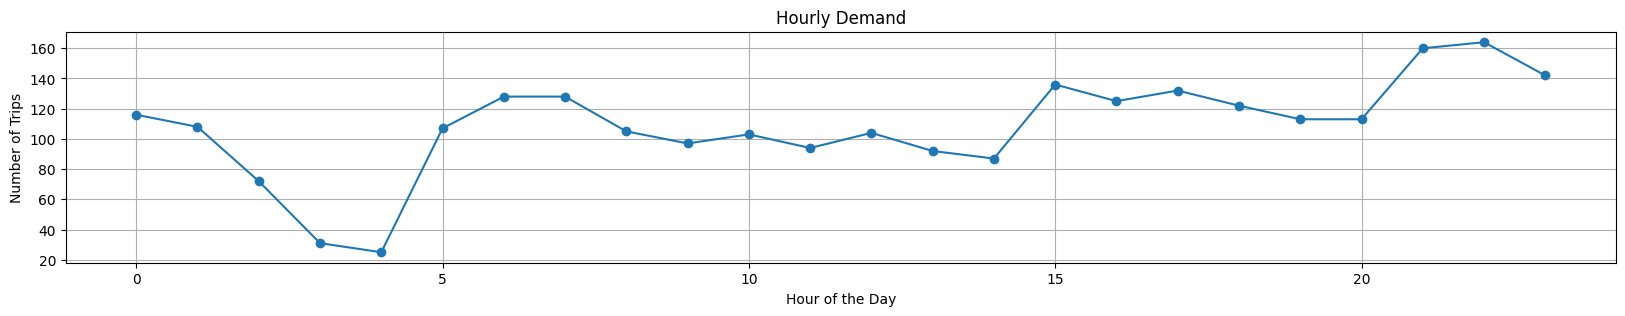

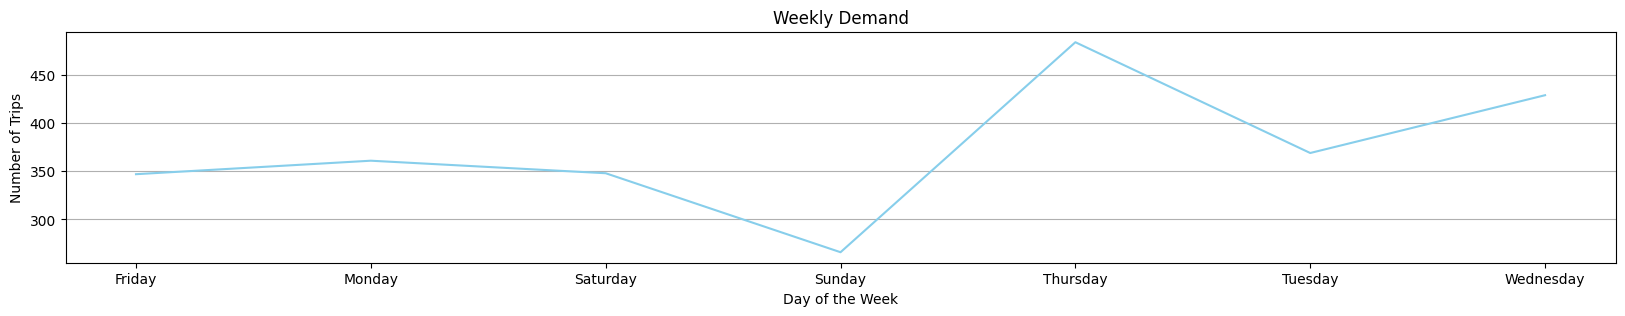

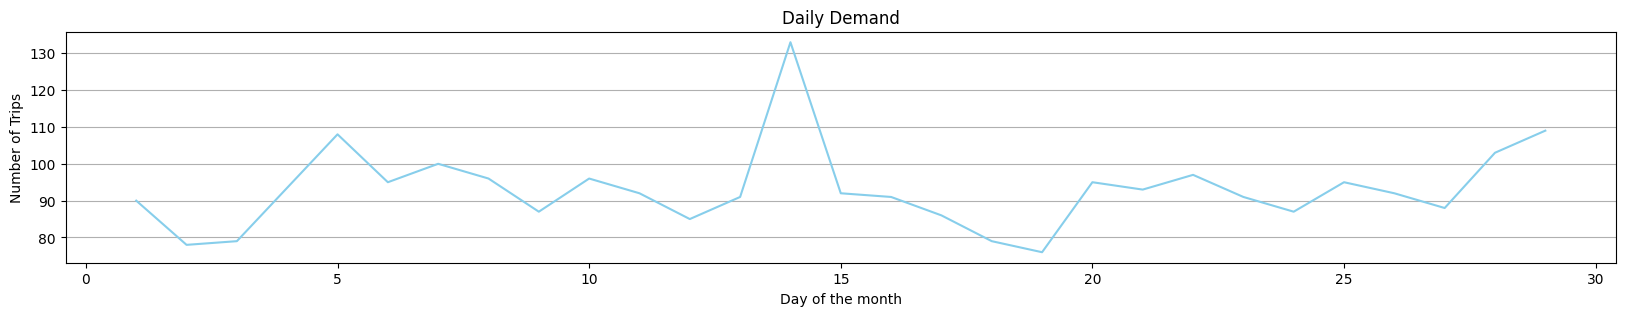

In [48]:
# Group data by hour and calculate the count of trips
hourly_demand_agg = data_processed_o.groupby('Hour of the day').size()
plt.figure(figsize=(20, 3))
hourly_demand_agg.plot(kind='line', marker='o')
plt.title('Hourly Demand')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.show()

# Group data by day of the week and calculate the count of trips
weekly_demand_agg = data_processed_o.groupby('Day of the week').size()
plt.figure(figsize=(20, 3))
weekly_demand_agg.plot(kind='line', color='skyblue')
plt.title('Weekly Demand')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Trips')
plt.grid(axis='y')
plt.show()

# Group data by day of the week and calculate the count of trips
daily_demand_agg = data_processed_o.groupby('Day of the month').size()
plt.figure(figsize=(20, 3))
daily_demand_agg.plot(kind='line', color='skyblue')
plt.title('Daily Demand')
plt.xlabel('Day of the month')
plt.ylabel('Number of Trips')
plt.grid(axis='y')
plt.show()

## **Postcode wise Analysis of hourly demand**

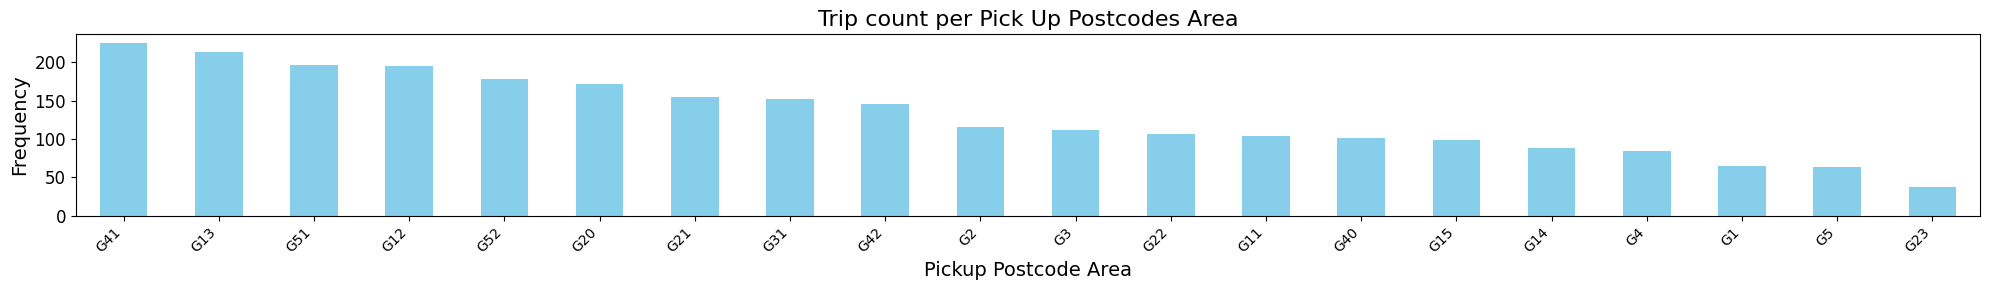

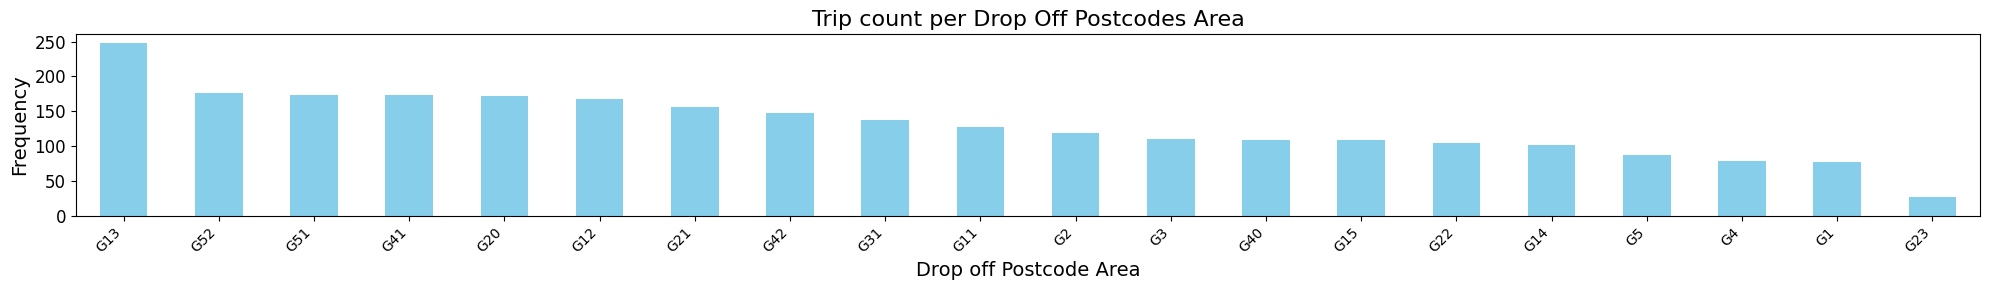

In [49]:
plt.figure(figsize=(20, 3))
data_processed_o['PostCodeArea_PickUp'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Trip count per Pick Up Postcodes Area', fontsize=16)
plt.xlabel('Pickup Postcode Area', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for better visibility
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 3))
data_processed_o['PostCodeArea_Dropoff'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Trip count per Drop Off Postcodes Area', fontsize=16)
plt.xlabel('Drop off Postcode Area', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for better visibility
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## **Identifying frequented routes through origin and destination post code areas**
Heat map of trip counts between post code areas

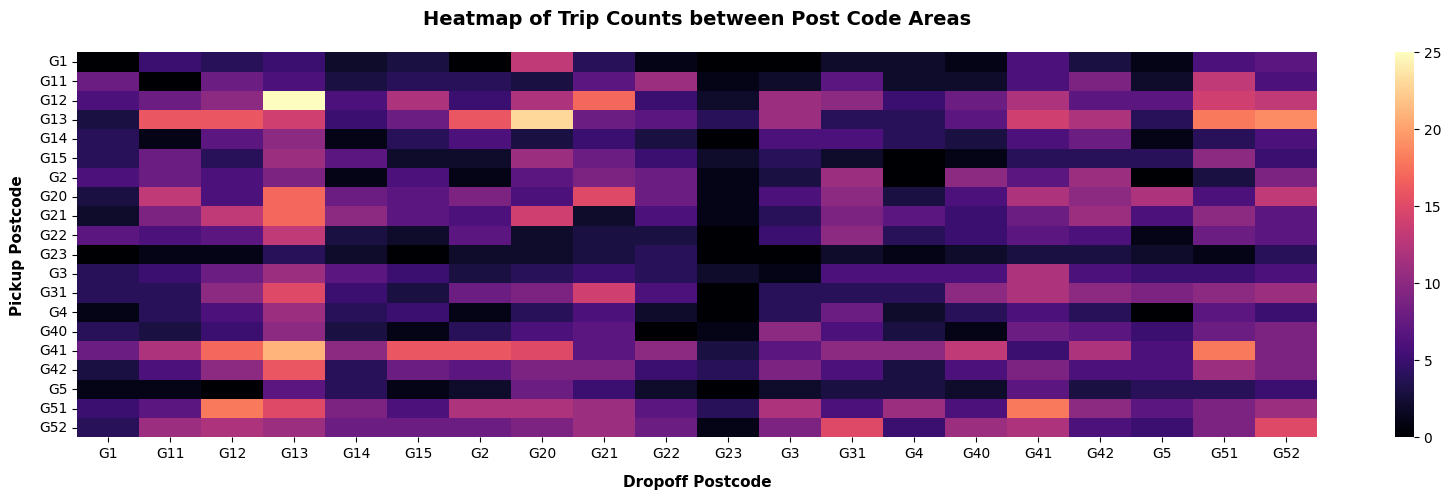

In [50]:
# Extract post code area columns for pickup and dropoff locations
heatmap_data = data_processed_o[['PostCodeArea_PickUp', 'PostCodeArea_Dropoff']]

# Create a pivot table with counts of trips between each post code area
heatmap_pivot = heatmap_data.pivot_table(index='PostCodeArea_PickUp', columns='PostCodeArea_Dropoff', aggfunc='size', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(20, 5))
sns.heatmap(heatmap_pivot, cmap='magma')
plt.title('Heatmap of Trip Counts between Post Code Areas', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Dropoff Postcode', fontsize=11, fontweight='bold', labelpad=10)
plt.ylabel('Pickup Postcode', fontsize=11, fontweight='bold', labelpad=10)
plt.show()

## **Rush Hour Analysis: Identifying busy post code areas for pick up**
Heatmap of trip counts between Pickup Post Code and Hour of the day

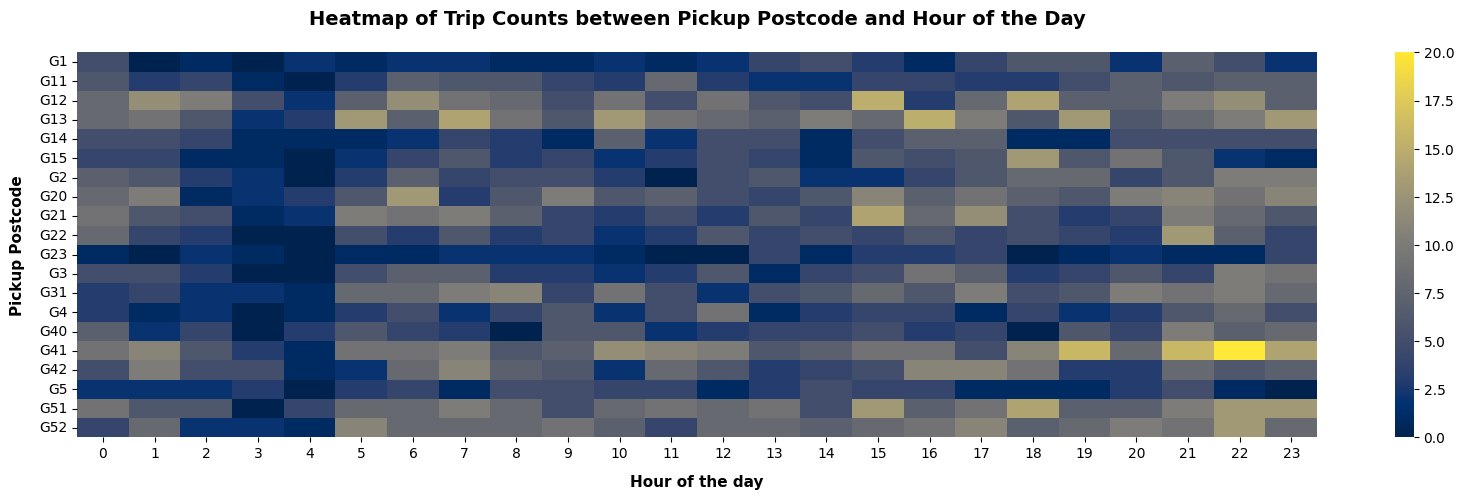

In [51]:
# Extract post code area column for pickup location and hour of the day
heatmap_data = data_processed_o[['PostCodeArea_PickUp', 'Hour of the day']]

# Create a pivot table with counts of trips between each post code area and hour of the day
heatmap_pivot = heatmap_data.pivot_table(index='PostCodeArea_PickUp', columns='Hour of the day', aggfunc='size', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(20, 5))
sns.heatmap(heatmap_pivot, cmap='cividis')
plt.title('Heatmap of Trip Counts between Pickup Postcode and Hour of the Day', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Hour of the day', fontsize=11, fontweight='bold', labelpad=10)
plt.ylabel('Pickup Postcode', fontsize=11, fontweight='bold', labelpad=10)
plt.show()

## **Rush Hour Analysis: Identifying busy post code areas for pick up**
Heatmap of trip counts between Dropoff Post Codes and Hour of the day

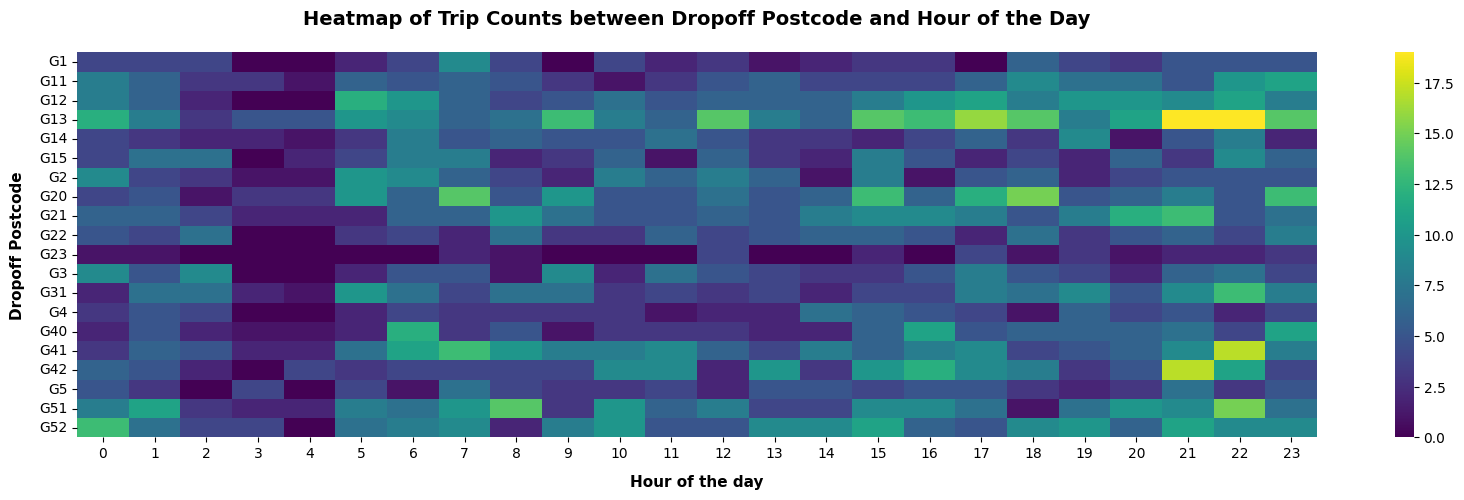

In [52]:
# Extract post code area column for pickup location and hour of the day
heatmap_data = data_processed_o[['PostCodeArea_Dropoff', 'Hour of the day']]

# Create a pivot table with counts of trips between each post code area and hour of the day
heatmap_pivot = heatmap_data.pivot_table(index='PostCodeArea_Dropoff', columns='Hour of the day', aggfunc='size', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(20, 5))
sns.heatmap(heatmap_pivot, cmap='viridis')
plt.title('Heatmap of Trip Counts between Dropoff Postcode and Hour of the Day', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Hour of the day', fontsize=11, fontweight='bold', labelpad=10)
plt.ylabel('Dropoff Postcode', fontsize=11, fontweight='bold', labelpad=10)
plt.show()

## **Hourly Variations and Outliers in Key Taxi Metrics: Demand, Distance, Duration, Fare, Tip, and Total Amount**

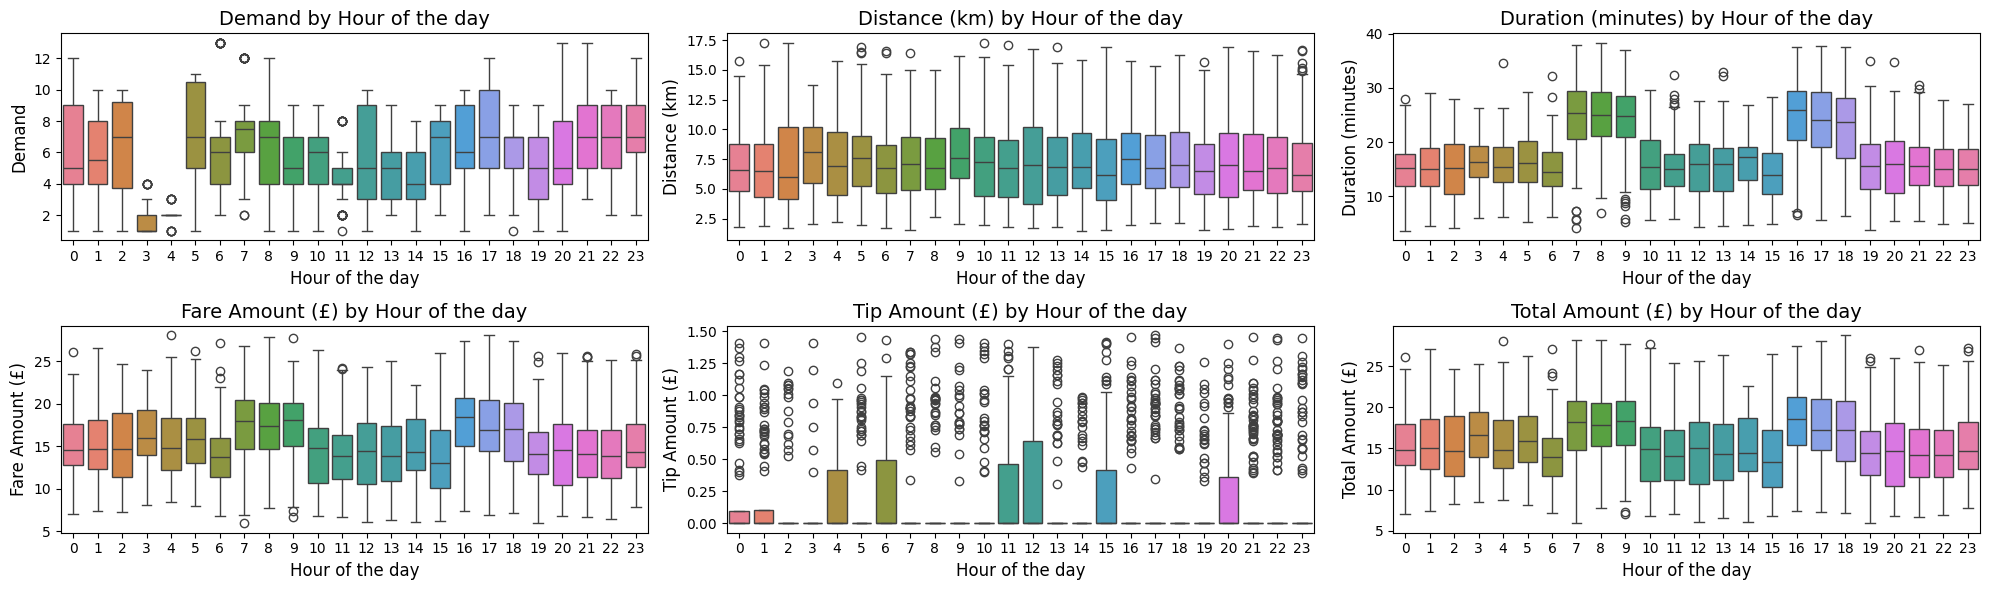

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

# Specify the categorical variable
categorical_variable = 'Hour of the day'

# Define the numerical variables
numerical_variables = ['Demand', 'Distance (km)', 'Duration (minutes)', 'Fare Amount (£)', 'Tip Amount (£)', 'Total Amount (£)']

# Determine the grid size for subplots
n_cols = 3  # Number of columns in the grid
n_rows = int(np.ceil(len(numerical_variables) / n_cols))  # Number of rows based on the number of numeric variables

# Use the `husl` palette
palette = sns.color_palette("husl", len(data_processed_o[categorical_variable].unique()))

# Create subplots for bivariate box plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3 * n_rows))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Loop through numerical variables and plot boxplots
for i, variable in enumerate(numerical_variables):
    sns.boxplot(x=categorical_variable, y=variable, data=data_processed_o, ax=axes[i], palette=palette)
    axes[i].set_title(f'{variable} by {categorical_variable}', fontsize=14)
    axes[i].set_xlabel(categorical_variable, fontsize=12)
    axes[i].set_ylabel(variable, fontsize=12)

# Hide any unused subplots
for j in range(len(numerical_variables), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

## **Revenue Analysis**

### Revenue per PostCode Area

In [54]:
# Aggregate the total amount by postcode area
total_amount_by_postcode = data_processed_o.groupby('PostCodeArea_PickUp')['Fare Amount (£)'].sum().reset_index()

# Rename columns for clarity
total_amount_by_postcode.columns = ['PostCodeArea_PickUp', 'Fare Amount (£)']

# Sort by total amount in descending order
total_amount_by_postcode = total_amount_by_postcode.sort_values(by='Fare Amount (£)', ascending=False)

# Display the result
print("Total Amount by Postcode Area:\n")
print(total_amount_by_postcode)

Total Amount by Postcode Area:

   PostCodeArea_PickUp  Fare Amount (£)
15                 G41          3632.08
3                  G13          3323.55
19                 G52          3013.66
18                 G51          2796.81
2                  G12          2718.40
8                  G21          2574.49
7                  G20          2493.66
12                 G31          2432.44
16                 G42          2372.31
5                  G15          1755.33
9                  G22          1703.56
6                   G2          1624.95
11                  G3          1565.34
14                 G40          1537.02
1                  G11          1483.33
4                  G14          1352.31
13                  G4          1193.68
0                   G1           964.84
17                  G5           854.20
10                 G23           632.16


### Revenue Zones

In [55]:
postcode_revenue_density = data_processed_o.groupby('PostCodeArea_PickUp')['Fare Amount (£)'].sum().reset_index()
postcode_revenue_density

# Define tiers
thresholds = [0, 2000, 4000, 6000]  # Adjust thresholds as needed
labels = ['Low', 'Medium', 'High']

# Categorize areas into revenue zones
postcode_revenue_density['Revenue_Zone'] = pd.cut(
    postcode_revenue_density['Fare Amount (£)'],
    bins=thresholds,
    labels=labels,
    include_lowest=True
)

# Group postcode areas by revenue zone
zones_with_postcodes = postcode_revenue_density.groupby('Revenue_Zone')['PostCodeArea_PickUp'].apply(list).reset_index()

# Display the results
print("Postcode Areas Categorized by Revenue Zone:")
print(zones_with_postcodes)

Postcode Areas Categorized by Revenue Zone:
  Revenue_Zone                                PostCodeArea_PickUp
0          Low  [G1, G11, G14, G15, G2, G22, G23, G3, G4, G40,...
1       Medium      [G12, G13, G20, G21, G31, G41, G42, G51, G52]
2         High                                                 []


## **Distributions of categorical features**

### **Countplots of categorical features**

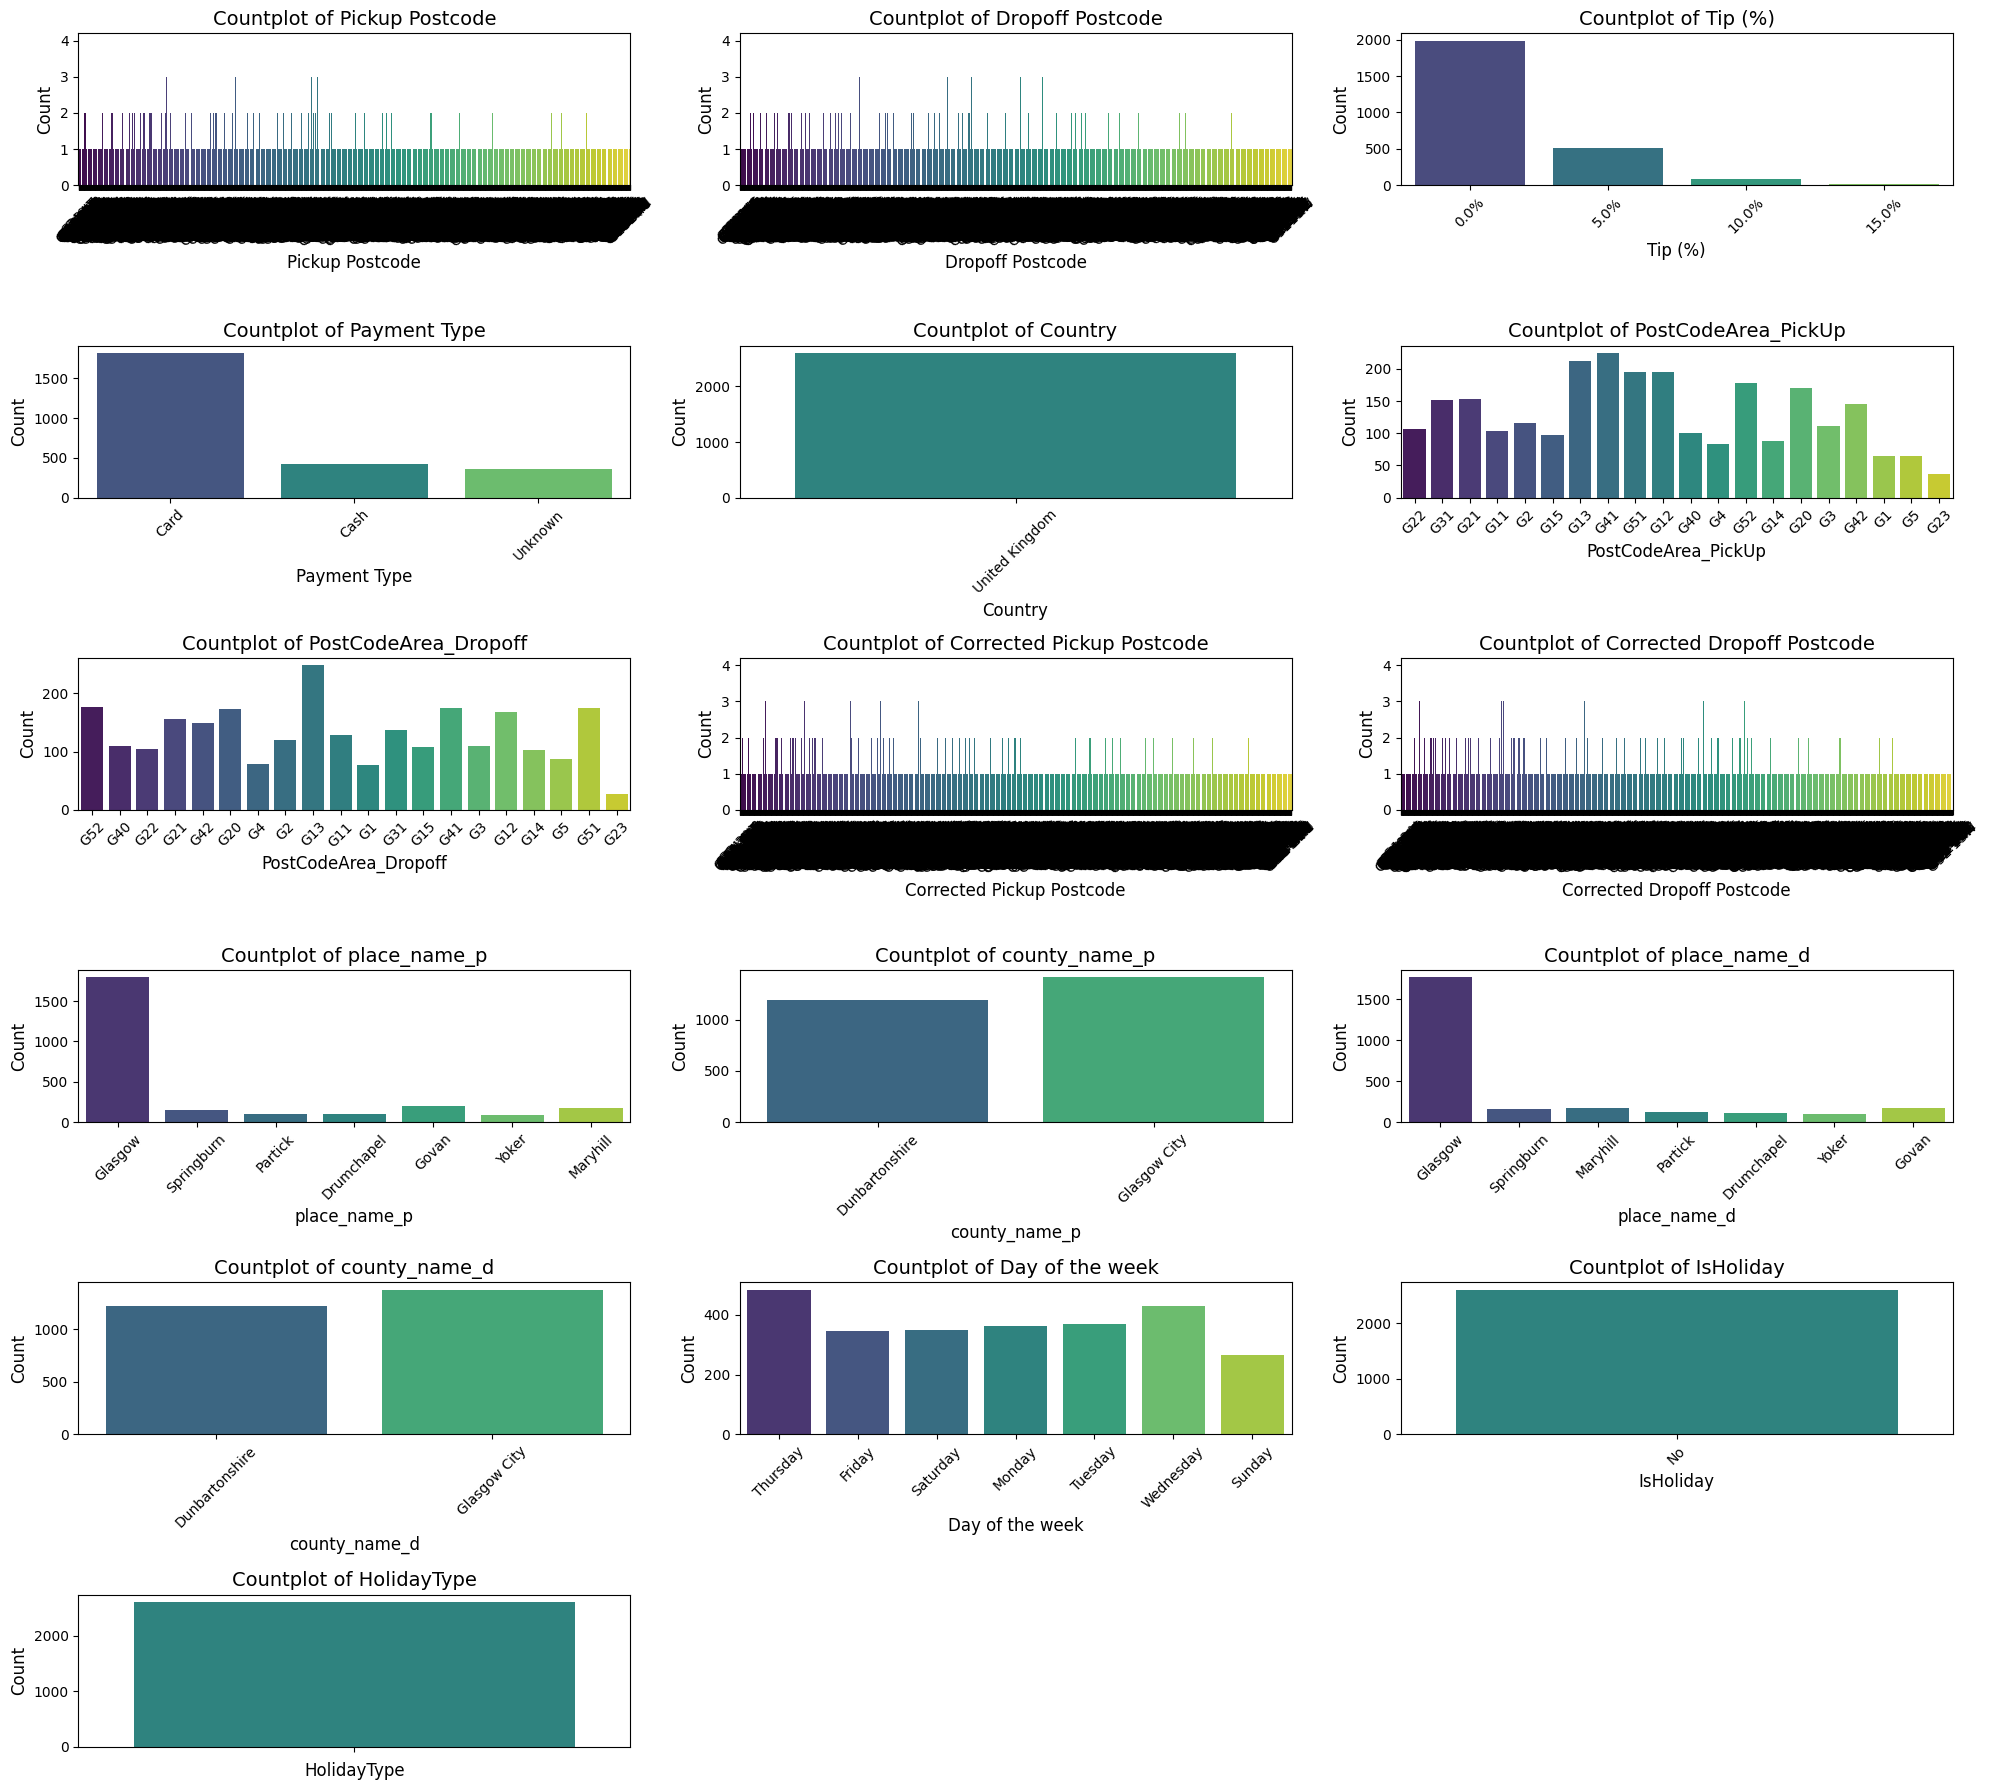

In [56]:

# Filter categorical columns
categorical_columns = [column for column in data_processed_o.columns if data_processed_o[column].dtype == 'object']

# Set up a 3-column grid for plotting
n_cols = 3
n_rows = int(np.ceil(len(categorical_columns) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3 * n_rows))

# Flatten axes for easier indexing
axes = axes.flatten()

# Plot each categorical column
for i, column in enumerate(categorical_columns):
    sns.countplot(x=column, data=data_processed_o, palette='viridis', ax=axes[i])
    axes[i].set_title(f'Countplot of {column}', fontsize=14)
    axes[i].set_xlabel(column, fontsize=12)
    axes[i].set_ylabel('Count', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(len(categorical_columns), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### **Pair plots for Key Taxi features**

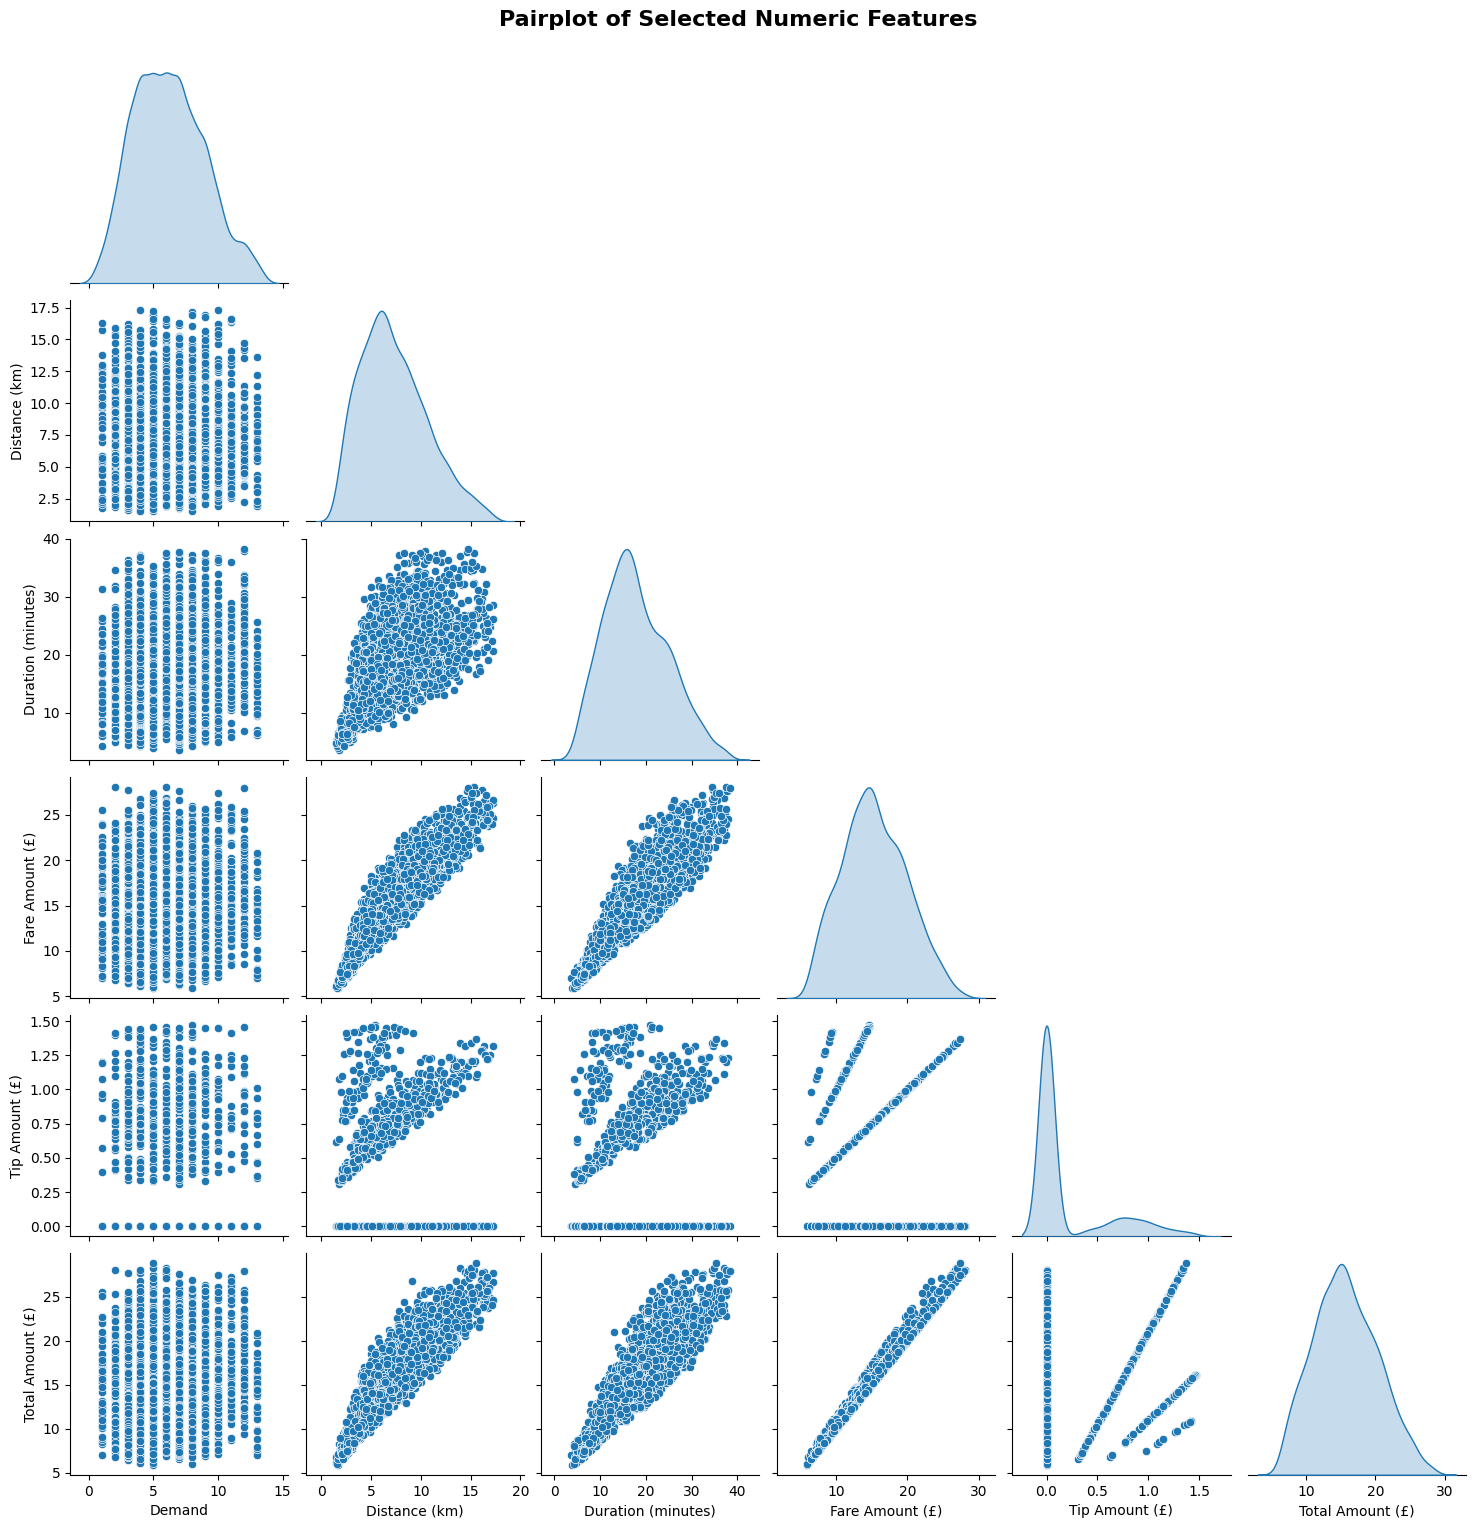

In [57]:
# Define the columns for the pairplot
columns_to_plot = ['Demand', 'Distance (km)', 'Duration (minutes)', 'Fare Amount (£)', 'Tip Amount (£)', 'Total Amount (£)']

# Generate the pairplot
sns.pairplot(data_processed_o[columns_to_plot], diag_kind='kde', corner=True, palette='husl')

# Customize plot
plt.suptitle("Pairplot of Selected Numeric Features", y=1.02, fontsize=16, fontweight='bold')
plt.show()

### **Overall Insights**

The relationships indicate logical correlations, such as:

- **Longer trips → Higher fares → Higher total amounts.**
- **Most trips are short in distance, duration, and cost.**

### **Diagonal KDE Plots**

These show the distribution of individual variables:

1. **`Demand`**:
   - The distribution is somewhat uniform, with no clear peaks.

2. **`Distance (km)`**:
   - **Right-skewed**: Indicating most trips are short, with fewer long-distance trips.

3. **`Duration (minutes)`**:
   - **Right-skewed**: Suggesting most trips are of shorter duration.

4. **`Fare Amount (£)`**:
   - **Right-skewed**: Consistent with shorter trips having lower fares.

5. **`Tip Amount (£)`**:
   - **Right-skewed**: Most tips are concentrated around lower values.

6. **`Total Amount (£)`**:
   - **Right-skewed**: Distributed broadly compared to other metrics.


### **Scatterplots (Off-Diagonal Plots)**

1. **`Demand` vs. `Distance` / `Duration` / `Fare`**:
   - **No clear trend**: Suggesting demand isn’t strongly correlated with these variables directly.

2. **`Distance` vs. `Duration`**:
   - **Positive correlation**: Longer distances generally take more time.

3. **`Distance` vs. `Fare Amount (£)`**:
   - **Positive correlation**: Higher fares are associated with longer trips.

4. **`Duration` vs. `Fare Amount (£)`**:
   - **Positive correlation**: Longer trips tend to have higher fares.

5. **`Fare Amount (£)` vs. `Tip Amount (£)`**:
   - **Weak positive correlation**: Higher fares tend to result in slightly higher tips.

6. **`Total Amount (£)` vs Other Variables**:
   - **Strong correlation** with `Fare Amount (£)` and `Distance`, as expected since `Total Amount (£)` is derived from these metrics.

## **Correlation Analysis**

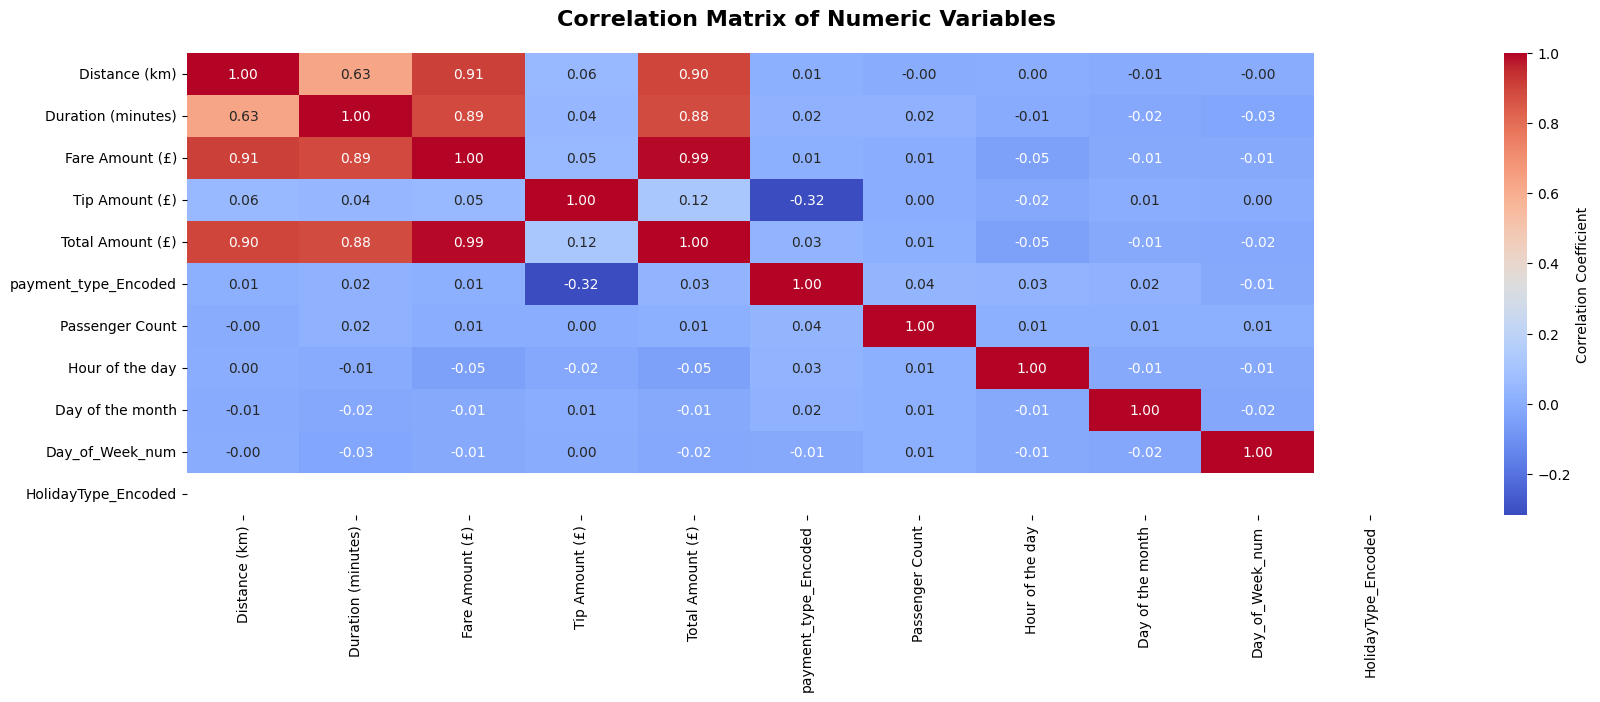

In [58]:
correlate_columns = ['Distance (km)',
       'Duration (minutes)', 'Fare Amount (£)', 'Tip Amount (£)',
       'Total Amount (£)', 'payment_type_Encoded', 'Passenger Count', 'Hour of the day', 'Day of the month', 'Day_of_Week_num',
       'HolidayType_Encoded']
data_for_corr = data_processed_o[correlate_columns]
correlation_matrix = data_for_corr.corr()
plt.figure(figsize=(20, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Correlation Matrix of Numeric Variables", fontsize=16, fontweight='bold', pad=20)
plt.show()

## **Passenger Analysis**

### Categorizing Post code areas based on the total passenger count

In [59]:
postcode_passenger_density = data_processed_o.groupby('PostCodeArea_PickUp')['Passenger Count'].sum().reset_index()
postcode_passenger_density

# Define tiers
thresholds = [0, 150, 300, 450]  # Adjust thresholds as needed
labels = ['Low', 'Medium', 'High']

# Categorize areas
postcode_passenger_density['Passenger_Tier'] = pd.cut(postcode_passenger_density['Passenger Count'], bins=thresholds, labels=labels, include_lowest=True)
postcode_passenger_density['Passenger_Tier'].value_counts()

# Group postcode areas by revenue zone
zones_with_passengers = postcode_passenger_density.groupby('Passenger_Tier')['PostCodeArea_PickUp'].apply(list).reset_index()

# Display the results
print("Postcode Areas Categorized by Passenger Count:\n")
print(zones_with_passengers)

Postcode Areas Categorized by Passenger Count:

  Passenger_Tier                                PostCodeArea_PickUp
0            Low              [G1, G14, G15, G22, G23, G4, G40, G5]
1         Medium  [G11, G12, G13, G2, G20, G21, G3, G31, G42, G5...
2           High                                              [G41]


In [60]:
postcode_revenue_density = df_cleansed.groupby('PostCodeArea_PickUp')['Fare Amount (£)'].sum().reset_index()
postcode_revenue_density

# Define tiers
thresholds = [0, 2000, 4000, 6000]  # Adjust thresholds as needed
labels = ['Low', 'Medium', 'High']

# Categorize areas into revenue zones
postcode_revenue_density['Revenue_Zone'] = pd.cut(
    postcode_revenue_density['Fare Amount (£)'],
    bins=thresholds,
    labels=labels,
    include_lowest=True
)

# Group postcode areas by revenue zone
zones_with_postcodes = postcode_revenue_density.groupby('Revenue_Zone')['PostCodeArea_PickUp'].apply(list).reset_index()

# Display the results
print("Postcode Areas Categorized by Revenue Zone:")
print(zones_with_postcodes)

Postcode Areas Categorized by Revenue Zone:
  Revenue_Zone                            PostCodeArea_PickUp
0          Low       [G1, G11, G14, G2, G23, G3, G4, G40, G5]
1       Medium  [G12, G15, G20, G21, G22, G31, G42, G51, G52]
2         High                                     [G13, G41]


## **Trip Duration Analysis and Rush Hour Analysis**

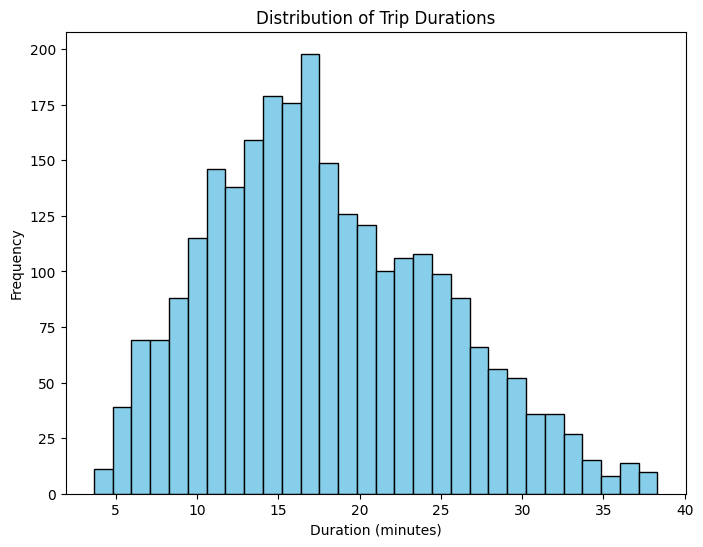

Trip Duration Statistics:
count    2604.000000
mean       17.920906
std         7.038590
min         3.650000
25%        12.770000
50%        17.025000
75%        22.867500
max        38.320000
Name: Duration (minutes), dtype: float64


In [61]:
# Trip duration analysis
trip_duration_stats = data_processed_o['Duration (minutes)'].describe()

# Visualize trip duration distribution
plt.figure(figsize=(8, 6))
plt.hist(data_processed_o['Duration (minutes)'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Trip Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

print("Trip Duration Statistics:")
print(trip_duration_stats)

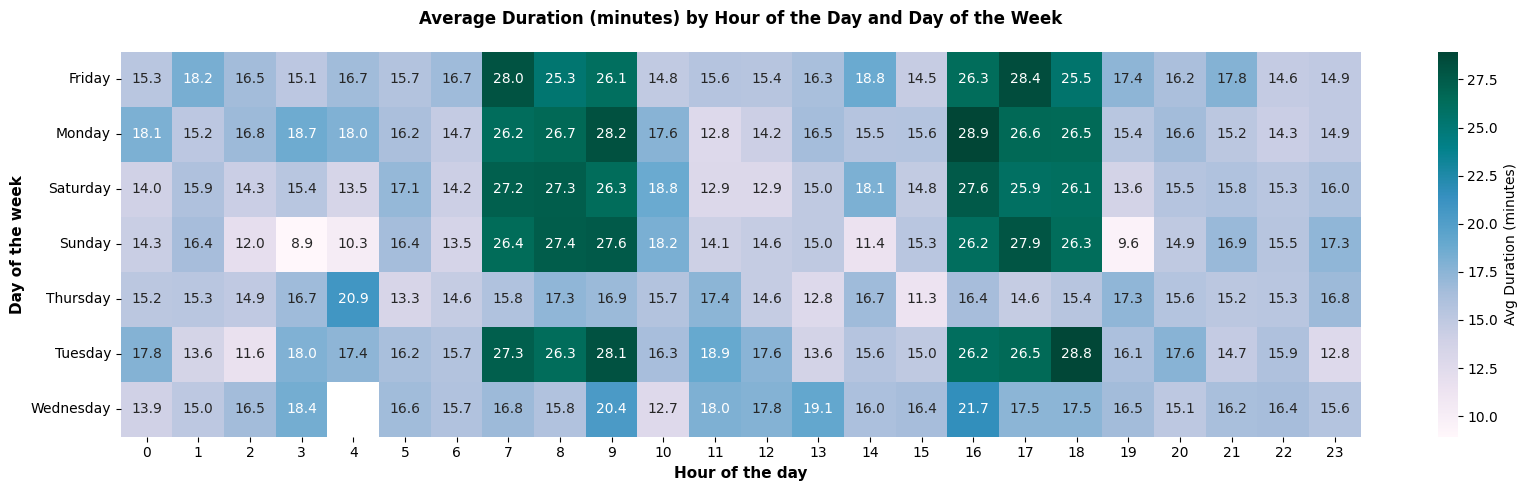

In [62]:
# Extract relevant columns: 'Day of the week', 'Hour of the day', and 'Duration (minutes)'
df_heat = data_processed_o[['Day of the week', 'Hour of the day', 'Duration (minutes)']]

# Group by 'Day of the week' and 'Hour of the day', calculate mean duration
df_heat = df_heat.groupby(["Day of the week", "Hour of the day"])["Duration (minutes)"].mean().reset_index()

# Pivot the DataFrame for heatmap plotting using keyword arguments
df_heat_pivot = df_heat.pivot(index="Day of the week", columns="Hour of the day", values="Duration (minutes)")

# Plotting the heatmap
plt.figure(figsize=(20, 5))
sns.heatmap(df_heat_pivot, cmap="PuBuGn", annot=True, fmt=".1f", cbar_kws={'label': 'Avg Duration (minutes)'})
plt.title("Average Duration (minutes) by Hour of the Day and Day of the Week", fontsize=12, fontweight='bold', pad=20)
plt.xlabel("Hour of the day", fontsize=11, fontweight='bold')
plt.ylabel("Day of the week", fontsize=11, fontweight='bold')
plt.show()


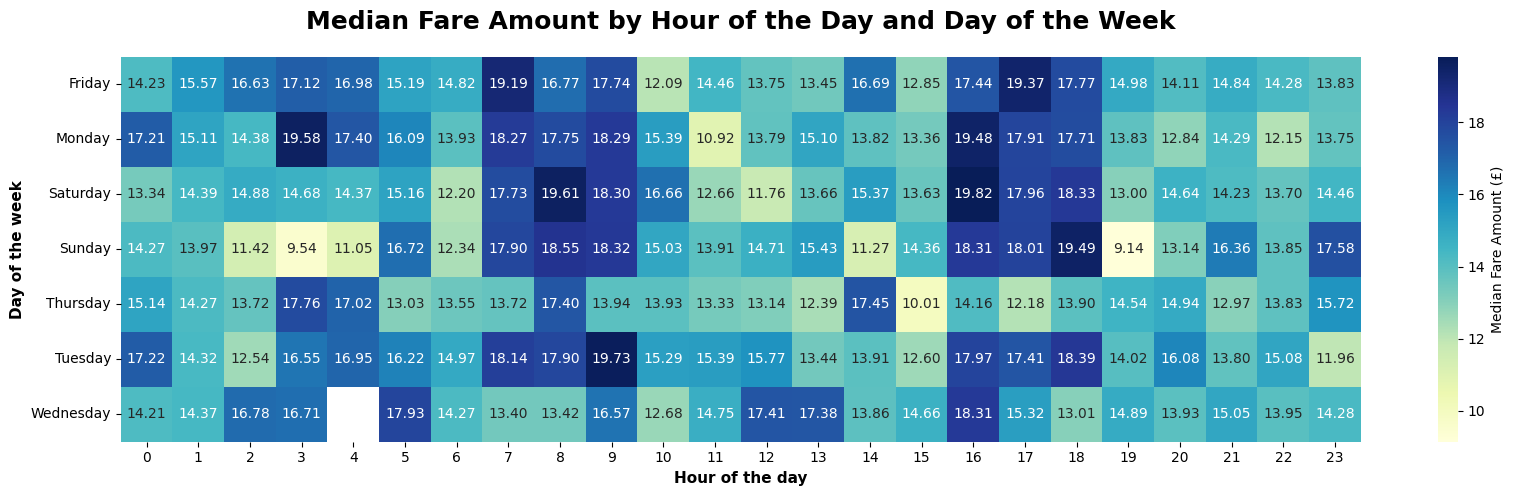

In [63]:
# Extract relevant columns: 'Day of the week', 'Hour of the day', and 'Duration (minutes)'
df_fare_heat = data_processed_o[['Day of the week', 'Hour of the day', 'Fare Amount (£)']]

# Group by 'Day of the week' and 'Hour of the day', calculate median fare amount
df_fare_heat = df_fare_heat.groupby(["Day of the week", "Hour of the day"])["Fare Amount (£)"].median().reset_index()

# Pivot the DataFrame for heatmap plotting
df_fare_heat_pivot = df_fare_heat.pivot(
    index="Day of the week",
    columns="Hour of the day",
    values="Fare Amount (£)"
)

# Plotting the heatmap
plt.figure(figsize=(20, 5))
sns.heatmap(df_fare_heat_pivot, cmap="YlGnBu", annot=True, fmt=".2f", cbar_kws={'label': 'Median Fare Amount (£)'})
plt.title("Median Fare Amount by Hour of the Day and Day of the Week", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Hour of the day", fontsize=11, fontweight='bold')
plt.ylabel("Day of the week", fontsize=11, fontweight='bold')
plt.show()


# **Key Performance Indicators**

## **Total Passenger Hours**
is the total time passengers spend being actively transported, aggregated across all trips

In [64]:
# Aggregate the total duration
total_active_time = data_processed_o['Duration (minutes)'].sum()

# Convert total time from minutes to hours
total_active_time_hours = total_active_time / 60

print("*****************    Total Passenger Hours:    ********************\n")
print(f"Total Active Time (in minutes): {total_active_time:.2f}")
print(f"Total Active Time (in hours): {total_active_time_hours:.2f}")

*****************    Total Passenger Hours:    ********************

Total Active Time (in minutes): 46666.04
Total Active Time (in hours): 777.77


## **Total Trips**

In [65]:
total_trips = data_processed_o.shape[0]
print(f"Total trips:\n{total_trips}")

Total trips:
2604


## **Postcode Revenues and Utilization Rates**

In [66]:
print(f"Total Active Time (in hours) available: {24*29:.2f}")

# Step 1: Aggregate the trip counts and total revenue by postcode area
postcode_utilization = data_processed_o.groupby('PostCodeArea_PickUp').agg(
    Total_Trips=('Fare Amount (£)', 'count'),  # Number of trips
    Total_Revenue=('Fare Amount (£)', 'sum')  # Total revenue
).reset_index()

# Step 2: Calculate the total trips and revenue for all areas
total_trips = postcode_utilization['Total_Trips'].sum()
total_revenue = postcode_utilization['Total_Revenue'].sum()

# Step 3: Calculate utilization rates for each postcode area
postcode_utilization['Utilization_Rate_Trips'] = np.round((postcode_utilization['Total_Trips'] / total_trips),2) * 100
postcode_utilization['Utilization_Rate_Revenue'] = np.round((postcode_utilization['Total_Revenue'] / total_revenue),2) * 100

# Step 4: Calculate overall utilization rate (for all areas combined)
overall_utilization_rate_trips = total_trips / len(data_processed_o) * 100  # Overall trips utilization rate
overall_utilization_rate_revenue = total_revenue / data_processed_o['Fare Amount (£)'].sum() * 100  # Overall revenue utilization rate

# Display the results
print("Overall Utilization Rates:")
print(f"Trips Utilization Rate: {overall_utilization_rate_trips:.2f}%")
print(f"Revenue Utilization Rate: {overall_utilization_rate_revenue:.2f}%\n")

print("Utilization Rates by Postcode Area:")
postcode_utilization

Total Active Time (in hours) available: 696.00
Overall Utilization Rates:
Trips Utilization Rate: 100.00%
Revenue Utilization Rate: 100.00%

Utilization Rates by Postcode Area:


,PostCodeArea_PickUp,Total_Trips,Total_Revenue,Utilization_Rate_Trips,Utilization_Rate_Revenue
0,G1,65,964.84,2.0,2.0
1,G11,104,1483.33,4.0,4.0
2,G12,195,2718.40,7.0,7.0
3,G13,213,3323.55,8.0,8.0
4,G14,88,1352.31,3.0,3.0
5,G15,98,1755.33,4.0,4.0
6,G2,116,1624.95,4.0,4.0
7,G20,171,2493.66,7.0,6.0
8,G21,154,2574.49,6.0,6.0
9,G22,106,1703.56,4.0,4.0


## **Postcode Revenue per KM**

In [67]:
# Step 1: Aggregate total revenue and distance by postcode area
postcode_revenue_per_km = df_cleansed.groupby('PostCodeArea_PickUp').agg(
    Total_Revenue=('Fare Amount (£)', 'sum'),
    Total_Distance=('Distance (km)', 'sum')
).reset_index()

# Step 2: Calculate revenue per km for each postcode area
postcode_revenue_per_km['Revenue_per_km'] = postcode_revenue_per_km['Total_Revenue'] / postcode_revenue_per_km['Total_Distance']

# Step 3: Handle division by zero
postcode_revenue_per_km['Revenue_per_km'] = postcode_revenue_per_km['Revenue_per_km'].replace([float('inf'), -float('inf')], None)

# Step 4: Display the results
print("Postcode Wise Revenue per km:")
print(postcode_revenue_per_km)

Postcode Wise Revenue per km:
   PostCodeArea_PickUp  Total_Revenue  Total_Distance  Revenue_per_km
0                   G1        1194.65         488.769        2.444202
1                  G11        1705.51         764.535        2.230781
2                  G12        3253.50        1408.001        2.310723
3                  G13        4076.32        1984.561        2.054016
4                  G14        1531.70         770.362        1.988286
5                  G15        2509.37        1325.113        1.893703
6                   G2        1986.23         814.599        2.438292
7                  G20        2826.45        1269.081        2.227163
8                  G21        3046.11        1597.583        1.906699
9                  G22        2411.20        1352.441        1.782850
10                 G23         702.05         337.007        2.083191
11                  G3        1791.89         724.984        2.471627
12                 G31        2847.10        1432.311       

## **Average Trip Duration**

In [68]:
# Calculate the average trip duration
average_trip_duration = total_active_time_hours / total_trips
print("Average Trip Duration (minutes):", average_trip_duration)

# Step 1: Aggregate average trip duration by postcode area
postcode_avg_duration = df_cleansed.groupby('PostCodeArea_PickUp').agg(
    Average_Duration=('Duration (minutes)', 'mean')
).reset_index()

# Step 2: Display the results
print("Postcode Wise Average Trip Duration:")
print(postcode_avg_duration)

Average Trip Duration (minutes): 0.29868177163338455
Postcode Wise Average Trip Duration:
   PostCodeArea_PickUp  Average_Duration
0                   G1         18.296024
1                  G11         16.633083
2                  G12         16.330766
3                  G13         18.846759
4                  G14         16.559010
5                  G15         22.926870
6                   G2         16.826111
7                  G20         16.733283
8                  G21         18.592692
9                  G22         22.273443
10                 G23         21.749250
11                  G3         16.448195
12                 G31         17.762928
13                  G4         16.857879
14                 G40         17.783740
15                 G41         18.730376
16                 G42         19.590667
17                  G5         15.288133
18                 G51         16.655734
19                 G52         19.324948


# **Time Series Analysis and Forecasting of Hourly Taxi Demand**
Aggregating data on hourly basis rather than daily basis to perform hour ahead forecasting.

## Normalising features

In [69]:
# Prepare train/test split for hour-ahead forecasting
train_size = int(len(hourly_demand) * 0.8)
train_main, test_main = hourly_demand[:train_size], hourly_demand[train_size:]

# Normalize features

# Scale the Demand column
scaler = MinMaxScaler()
scaled_demand = scaler.fit_transform(hourly_demand[['Demand']])

columns_to_scale = ['Demand', 'Day_of_Week_num', 'Hour of the day']
scaled_features = scaler.fit_transform(data_merged[columns_to_scale])
scaled_df = pd.DataFrame(scaled_features, columns=columns_to_scale)
scaled_df.head()

NameError: name 'data_merged' is not defined

## **Checking stationarity, seasonality of dataset**

In [ ]:
plt.figure(figsize=(20, 6))
plt.plot(hourly_demand)
plt.title('Hourly Taxi Demand', fontsize=20, pad=20, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.show()

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Decompose the hourly time series
decomposition = seasonal_decompose(demand_series, model='additive', period=24)  # 24-hour seasonality
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 5))
plt.subplot(411)
plt.plot(hourly_demand, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# Check stationarity with Augmented Dickey-Fuller test (optional)
# The ADF test checks whether the time series is stationary (constant mean and variance over time)
from statsmodels.tsa.stattools import adfuller
result = adfuller(train_main.dropna()) # Drop NaN values as the test requires non-missing data
print("\n\n***************Augmented Dickey-Fuller Test Results for Stationarity Check********************\n")
print('ADF Statistic - numerical measure of stationarity: ', result[0])
print('p-value - Probability of the data being non-stationary:', result[1])
print(f"Critical Values: {result[4]}")

# Check stationarity based on p-value
if result[1] < 0.05:
    print("\nConclusion: The data is stationary (p-value < 0.05).\n\n")
else:
    print("\nConclusion: The data is NOT stationary (p-value >= 0.05).\n\n")

# Plot ACF and PACF
plot_acf(train_main.dropna(), lags=48)
plt.show()
plot_pacf(train_main.dropna(), lags=48)
plt.show()


**Nature of hourly demand data**

* Original Data: Underlying data is stationary as per Augmented Dickey Fuller Test. There's no clear upward or downward trend at first glance. The variability suggests periodic or seasonal patterns.
* Trend: The overall demand appears relatively stable but fluctuates slightly around a consistent mean. The slight upward or downward movement might represent broader shifts in demand (e.g., specific days or events causing changes).
* Seasonality: The visual analysis indicates seasonality in the data. Actual demand fluctuates over hours, with identifiable peaks and dips. The demand is higher during certain times of the day (peaks) and lower during others (troughs) indicating periods of rush hours. The pattern strongly confirms daily seasonality in the data
* The residuals appear to be centered around zero, with no clear pattern or structure. This randomness suggests that most of the systematic patterns in the data are well-captured by the trend and seasonality components.

## **Forecasting using ARIMA Model**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Step 6: Fit an ARIMA model
train_arima = train_main
test_arima = test_main

model_arima = ARIMA(train_arima, order=(2, 1, 2))  # Adjust ARIMA parameters based on ACF/PACF
model_fit = model_arima.fit()
print(model_fit.summary())

# Step 7: Forecast for the test period
forecast_arima = model_fit.forecast(steps=len(test_arima))
mse_arima = mean_squared_error(test_arima, forecast_arima)
print('\n\n*******************Test MSE:**********************\n', mse_arima)

# Step 8: Plot the forecast
plt.figure(figsize=(15, 5))
plt.plot(test_arima.index, test_arima, label='Actual')
plt.plot(test_arima.index, forecast_arima, color='red', label='Forecast')
plt.legend()
plt.title('Hourly Taxi Demand Forecast (ARIMA)\n The plot shows the actual hourly taxi demand (blue line) versus the forecasted demand (red line) generated by the ARIMA model\n\n', fontweight='bold', fontsize=20, pad=20)
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.show()


**Model Interpretation**


**Summary of the ARIMA(2, 1, 2) model fitted to the time series data**

* hourly taxi demand is the dependent variable being forecasted
* total number of observations used for modelling in 556 observations
* ARIMA(2, 1, 2):
  * AR (2): Two autoregressive terms.
  * I (1): First-order differencing to make the data stationary.
  * MA (2): Two moving average terms

* The ARIMA(2, 1, 2) model fits the data reasonably well based on AIC and BIC values.
* Residuals appear uncorrelated but are not normally distributed. This may not significantly affect the model's forecasting ability but is worth noting for further improvement
* Test MSE of 7.116 is reasonably low, indicating the model provides accurate forecasts.

**Insights from the Forecast**
* **Flat Forecast (Red Line):** The ARIMA model predicts a near-constant demand level (~4 trips per hour) over the test period.
This suggests that the model struggles to capture the hourly fluctuations in the actual demand (blue line).

* **Actual Demand (Blue Line):** The actual demand fluctuates significantly, with some hours having peaks (>10 trips) and others dropping to near zero.
This indicates high variability in hourly taxi demand that the ARIMA model did not fully capture.


**Issues with ARIMA forecast**
* The ARIMA model forecast is overly simplistic, failing to capture the peaks and valleys in hourly demand. This could lead to operational inefficiencies, such as under-deploying taxis during high-demand periods or over-deploying during low-demand periods.
* The ARIMA model may not account for seasonality (e.g., daily or weekly patterns) and abrupt changes in demand.
* A seasonal model (SARIMA) or more advanced approaches like machine learning (LSTM, Prophet) might be better suited for this data.


**Business Insights from ARIMA Model**

* The seasonal component confirms strong daily seasonality, with repeating patterns every 24 hours. This likely corresponds to higher demand during specific hours of the day and lower demand during off-peak hours (e.g., late night or early morning).
* The trend is relatively stable, with minor dips and rises indicating small changes in overall demand.

## **Forecasting using HoltsWinter Exponential Smoothing**

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

print(f"\n\n*********************Holts Winter Exponential Smoothing***********************\n\n")

train_hw = train_main
test_hw = test_main

# Step 3: Fit the Holt-Winters model
# Use additive seasonality, trend, and level (adjust for your data characteristics)
model_hw = ExponentialSmoothing(
    train_hw,
    trend="add",
    seasonal="add",
    seasonal_periods=24  # Daily seasonality for hourly data
).fit()

# Step 4: Forecast for the test period
forecast_hw = model_hw.forecast(steps=len(test_hw))

# Step 5: Evaluate the model
mse_hw = mean_squared_error(test_hw, forecast_hw)
print(f"\nTest MSE: {mse_hw}")

# Step 6: Plot actual vs. forecast
plt.figure(figsize=(15, 6))
plt.plot(train_hw.index, train_hw, label="Train")
plt.plot(test_hw.index, test_hw, label="Actual")
plt.plot(test_hw.index, forecast_hw, label="Forecast", color="red")
plt.title("Holt-Winters Forecast of Hourly Taxi Demand")
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.legend()
plt.show()


* The Holt-Winters model successfully captures daily seasonality, ensuring the forecast reflects predictable patterns in demand.
* Low MSE indicates a reliable prediction for most hours.

**Business Implications from Holts Winter Forecasting**

* **Fleet Optimization:**

  * Deploy more taxis during forecasted peak hours to reduce wait times and increase revenue.
  * Scale down operations during off-peak hours to save costs.
* **Dynamic Pricing:**

  * Implement surge pricing during high-demand periods to maximize profits.
  * Offer discounts in low-demand hours to boost ridership.
* **Driver Scheduling:**

  * Align driver shifts with demand patterns, ensuring optimal coverage during busy periods.
* **Customer Satisfaction:**

  * Reduce cancellations and wait times by forecasting and meeting demand effectively.
* **Cost Efficiency:**

  * Avoid over-deployment during troughs, minimizing idle time and operational expenses

## **Forecasting using SARIMA**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

print("\n\n **************SARIMA Forecasting Model to capture daily or weekly seasonal patterns in the data.*************\n")
# Step 3: Fit SARIMA model
# Order = (p, d, q), Seasonal Order = (P, D, Q, s) with s = 24 (daily seasonality for hourly data)

train_sarima = train_main
test_sarima = test_main

sarima_model = SARIMAX(train_sarima, order=(2, 1, 2), seasonal_order=(1, 1, 1, 24))
sarima_fit = sarima_model.fit()

# Step 4: Forecast
forecast_sarima = sarima_fit.forecast(steps=len(test_sarima))

# Step 5: Evaluate and plot
mse_sarima = mean_squared_error(test_sarima, forecast_sarima)
print(f"\n\n****SARIMA Test MSE: {mse_sarima}")

plt.figure(figsize=(15, 6))
plt.plot(train_sarima.index, train_sarima, label='Train')
plt.plot(test_sarima.index, test_sarima, label='Actual')
plt.plot(test_sarima.index, forecast_sarima, label='Forecast', color='red')
plt.title("SARIMA Forecast of Hourly Taxi Demand", fontweight=20, fontsize=20, pad=20)
plt.xlabel("Date")
plt.ylabel("Number of Trips")
plt.legend()
plt.show()


## **Forecasting using LSTM (Long Short-Term Memory) Neural Network**

### **LSTM Model on Demand only**

In [ ]:
print("\n\n*****************    LSTM Model for taxi demand without external factors considered    ****************\n")

# Step 2: Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Past sequence (input)
        y.append(data[i+seq_length])   # Target (next value)
    return np.array(X), np.array(y)

seq_length = 24  # Use the past 24 hours to predict the next hour
X_demand, y_demand = create_sequences(scaled_demand, seq_length)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_demand, y_demand, test_size=0.2, random_state=42)

# Step 3: Build the LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))  # Predicting next demand value
model.compile(optimizer='adam', loss='mse')

# Step 4: Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Step 5: Evaluate the Model
predictions = model.predict(X_test)

# Inverse transform the predictions and test set
# Add dummy columns to match the original shape used during scaling
dummy_columns = np.zeros((len(y_test), 2))  # Add 2 dummy columns to match 3-column shape
y_test_with_dummies = np.concatenate([y_test.reshape(-1, 1), dummy_columns], axis=1)
predictions_with_dummies = np.concatenate([predictions.reshape(-1, 1), dummy_columns], axis=1)

# Perform inverse transformation
y_test_rescaled = scaler.inverse_transform(y_test_with_dummies)[:, 0]  # Extract only the Demand column
predictions_rescaled = scaler.inverse_transform(predictions_with_dummies)[:, 0]  # Extract only the Demand column

# Calculate MSE
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
print(f"Test MSE: {mse}")

# Step 6: Plot Actual vs Predicted
plt.figure(figsize=(15, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(predictions_rescaled, label='Forecast', color='red')
plt.title("LSTM Forecast of Hourly Demand without external factors", pad=20, fontweight=20, fontsize=20)
plt.xlabel("Hours")
plt.ylabel("Demand")
plt.legend()
plt.show()


The test set likely consists of 120 hours (5 days × 24 hours), which is the result of the train-test split (e.g., 80% training, 20% testing) of the original time series data.
LSTM uses sequences of past data (e.g., the past 24 hours) to predict the next hour. The test dataset represents 120 predicted hours.
The x-axis values (0 to 120) correspond to the indices of the hourly predictions in the test dataset, not calendar time or dates.

* The blue line represents the actual hourly taxi demand, which shows significant variability and abrupt spikes.
* The red line represents the LSTM forecast, which appears smoother and does not fully capture the sharp peaks or troughs in the actual demand. The forecasted values are overly smoothed, meaning the model struggles to predict extreme spikes or dips in demand.

### **LSTM Model including Day of the Week, Time of the Day, and Weather/Events**

In [ ]:
print("\n\n*****************LSTM Model including Day of the Week, Time of the Day, and Weather/Events****************\n")

# Step 2: Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])  # Use all features
        y.append(data[i+seq_length, 0])   # Target is the Demand column
    return np.array(X), np.array(y)

seq_length = 24  # Use the past 24 hours to predict the next hour
X, y = create_sequences(scaled_df.values, seq_length)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Build the LSTM Model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))  # Predicting Demand
model.compile(optimizer='adam', loss='mse')

# Step 4: Train the Model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Step 5: Evaluate the Model
predictions = model.predict(X_test)

# Inverse transform the predictions and test set
y_test_rescaled = scaler.inverse_transform(np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), 2))], axis=1))[:, 0]
predictions_rescaled = scaler.inverse_transform(np.concatenate([predictions, np.zeros((len(predictions), 2))], axis=1))[:, 0]

mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
print(f"\n\n*************************Test MSE: {mse}")

# Step 6: Plot Actual vs Predicted
plt.figure(figsize=(15, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(predictions_rescaled, label='Forecast', color='red')
plt.title("LSTM Forecast of Hourly Taxi Demand including Day of the Week, Time of the Day, and Weather/Events", pad=20, fontweight=20, fontsize=20)
plt.xlabel("Hours")
plt.ylabel("Demand")
plt.legend()
plt.show()

## **Choosing between SARIMA and LSTM**

### Checking for Linearity

In [ ]:
from sklearn.linear_model import LinearRegression

time = np.arange(len(hourly_demand)).reshape(-1, 1)  # Time as independent variable
demand = hourly_demand.values  # Demand as dependent variable
model = LinearRegression().fit(time, demand)
print(f"R-squared: {model.score(time, demand)}. ")


An R-squared value of 0.008 indicates that the linear relationship between time (independent variable) and hourly demand (dependent variable) is extremely weak. Only ~0.8% of the variability in hourly demand is explained by time.
The data does not follow a strong linear trend over time.

Hourly taxi demand has variability in demand is likely influenced by nonlinear factors (e.g., seasonality, external events, or random fluctuations).

# **K-Means Hotspot Analysis**

Goal is to
- Identify geographical hotspots for:
  - **Pickups**
  - **Drop-offs**
- Focus on areas with high activity to optimize operations.

How to Implement:
1. **Features to cluster**:
   - Latitude and Longitude of pickup/drop-off points.
2. **Clustering**:
   - Apply K-Means clustering to define key hotspots.
3. **Visualization**:
   - Overlay the clusters on a map using tools like Tableau or Folium.
   - Highlight high-demand areas for actionable insights.


In [ ]:
data_processed_o.columns

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import folium
import seaborn as sns
import matplotlib.pyplot as plt

data_k_hotspot = data_processed_o.copy()

# Step 1: Extract latitude and longitude for clustering
features = data_k_hotspot[['latitude_p', 'longitude_p']]

# Step 2: Perform K-means clustering
n_clusters = 4  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
data_k_hotspot['Cluster'] = kmeans.fit_predict(features)


In [ ]:
# Save the dataset to a CSV file for Tableau
data_k_hotspot.to_csv("/content/kmeans_hotspots.csv", index=False)

In [ ]:
import os

# Check if the file exists
file_path = '/content/kmeans_hotspots.csv'
if os.path.exists(file_path):
    print("File exists:", file_path)
else:
    print("File does not exist!")

from google.colab import files
files.download('/content/kmeans_hotspots.csv')

# **Identifying Trip Patterns using K-means clustering**

### Goal:
- Cluster trips based on trip characteristics such as:
  - **Trip duration**
  - **Fare amount**
  - **Distance traveled**
- Identify typical trip types, e.g.:
  - Short-duration trips
  - Long-distance trips
  - High-revenue trips




In [ ]:
data_k_features = data_processed_o.copy()

# Step 1: Select features for clustering
features = data_k_features[['Duration (minutes)', 'Distance (km)', 'Fare Amount (£)']]

# Step 2: Normalize the data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Step 3: Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_features)

# Step 4: Add cluster labels to the dataset
data_k_features['Cluster'] = kmeans.labels_

# Step 5: Visualize the clusters
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data_k_features,
    x='Duration (minutes)',
    y='Fare Amount (£)',
    hue='Cluster',
    palette='tab10',
    size='Distance (km)',
    sizes=(50, 200),
    alpha=0.8
)
plt.title("K-Means Clustering: Trip Patterns", fontsize=16)
plt.xlabel("Duration (minutes)", fontsize=12)
plt.ylabel("Fare Amount (£)", fontsize=12)
plt.legend(title='Cluster', loc='upper left', fontsize=10)
plt.grid(True)
plt.show()

# Display the resulting dataset with cluster labels
print("Dataset with Cluster Labels:")
print(data_k_features)


In [ ]:
# Save the dataset to a CSV file for Tableau
data_k_hotspot.to_csv("/content/kmeans_features.csv", index=False)

import os

# Check if the file exists
file_path = '/content/kmeans_features.csv'
if os.path.exists(file_path):
    print("File exists:", file_path)
else:
    print("File does not exist!")

from google.colab import files
files.download('/content/kmeans_features.csv')

## **Customer Segmentation using K Means**

Goal is to Cluster customers based on their behavior to:
  - Tailor marketing strategies.
  - Offer personalized promotions or services.

1. **Features to cluster**:
   - Total spending.
   - Trip frequency.
   - Average trip distance.
   - Preferred times of travel.
2. **Clustering**:
   - Apply clustering techniques (e.g., K-Means) to segment customers.
3. **Cluster Types**:
   - Frequent travelers.
   - High spenders.
   - Long-distance travelers.
4. **Utilization**:
   - Use the segmented results to design:
     - Targeted promotional campaigns.
     - Custom services for specific customer segments.


## Fleet Optimization

- Optimize fleet allocation by understanding demand patterns based on time and location.

1. **Features to cluster**:
   - Day of the week.
   - Hour of the day.
   - Postcode area.
2. **Clustering**:
   - Use clustering techniques (e.g., K-Means) to identify demand patterns.
3. **Insights**:
   - Identify temporal clusters (e.g., peak hours, weekdays vs weekends).
   - Identify spatial clusters (e.g., high-demand postcode areas).
4. **Utilization**:
   - Allocate vehicles efficiently to:
     - Meet demand during peak hours.
     - Serve high-demand areas with optimized fleet distribution.
